# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

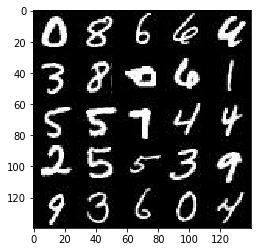

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

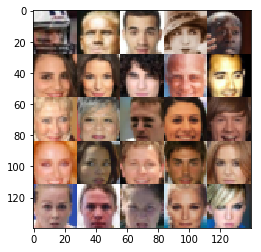

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        conv1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', 
                                 kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        #conv1 = tf.nn.relu(conv1)
        conv1 = tf.maximum(0.2*conv1, conv1)
        # 14x14x128
        
        conv2 = tf.layers.conv2d(conv1, 256, 5, strides=2, padding='same',
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        #conv2 = tf.nn.relu(conv2)
        conv2 = tf.maximum(0.2*conv2, conv2)
        # 7x7x256
        
        conv3 = tf.layers.conv2d(conv2, 512, 5, strides=2, padding='same',
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        #conv3 = tf.nn.relu(conv3)
        conv3 = tf.maximum(0.2*conv3, conv3)
        # 4x4x512

        # Flatten it
        flat = tf.reshape(conv3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        fc = tf.layers.dense(z, 5 * 5 * 512, 
                             kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        fc = tf.reshape(fc, [-1, 5, 5, 512])
        fc = tf.layers.batch_normalization(fc, training=is_train)
        #fc = tf.nn.relu(fc)
        fc = tf.maximum(0.2*fc, fc)
        # 5x5x512
        
        convt1 = tf.layers.conv2d_transpose(fc, 256, 3, strides=1, padding='valid',
                                            kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        convt1 = tf.layers.batch_normalization(convt1, training=is_train)
        #convt1 = tf.nn.relu(convt1)
        convt1 = tf.maximum(0.2*convt1, convt1)
        # 7x7x256
        
        
        convt2 = tf.layers.conv2d_transpose(convt1, 128, 5, strides=2, padding='same', 
                                            kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        convt2 = tf.layers.batch_normalization(convt2, training=is_train)
        #convt2 = tf.nn.relu(convt2)
        convt2 = tf.maximum(0.2*convt2, convt2)
        # 14x14x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(convt2, out_channel_dim, 5, strides=2, padding='same',
                                            kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        # 28x28x3
        
        out = tf.tanh(logits)/2 #need scale -0.5~0.5?
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [29]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [30]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [37]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    out_channel_dim = 3 if data_image_mode == 'RGB' else 1 
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    with tf.Session() as sess:

        steps = 0
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 10, input_z, out_channel_dim, data_image_mode)
        show_generator_output(sess, 10, input_z, out_channel_dim, data_image_mode)
        saver = tf.train.Saver()
        saver.save(sess, './checkpoints/generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1850... Generator Loss: 4.2194
Epoch 1/2... Discriminator Loss: 1.2561... Generator Loss: 1.4965
Epoch 1/2... Discriminator Loss: 1.2926... Generator Loss: 0.8693
Epoch 1/2... Discriminator Loss: 1.3642... Generator Loss: 1.0450
Epoch 1/2... Discriminator Loss: 2.5432... Generator Loss: 3.9999
Epoch 1/2... Discriminator Loss: 2.2913... Generator Loss: 1.7261
Epoch 1/2... Discriminator Loss: 1.0921... Generator Loss: 0.9181
Epoch 1/2... Discriminator Loss: 2.3878... Generator Loss: 0.2318
Epoch 1/2... Discriminator Loss: 1.8427... Generator Loss: 0.2488
Epoch 1/2... Discriminator Loss: 1.7809... Generator Loss: 0.3012


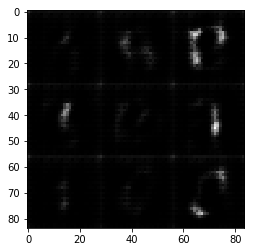

Epoch 1/2... Discriminator Loss: 1.5449... Generator Loss: 0.3420
Epoch 1/2... Discriminator Loss: 2.0049... Generator Loss: 0.2298
Epoch 1/2... Discriminator Loss: 1.4180... Generator Loss: 0.4617
Epoch 1/2... Discriminator Loss: 1.8803... Generator Loss: 0.2179
Epoch 1/2... Discriminator Loss: 2.0433... Generator Loss: 2.5183
Epoch 1/2... Discriminator Loss: 1.2903... Generator Loss: 1.8313
Epoch 1/2... Discriminator Loss: 1.9126... Generator Loss: 2.0005
Epoch 1/2... Discriminator Loss: 1.9406... Generator Loss: 2.2347
Epoch 1/2... Discriminator Loss: 1.4950... Generator Loss: 1.3660
Epoch 1/2... Discriminator Loss: 1.5893... Generator Loss: 1.4975


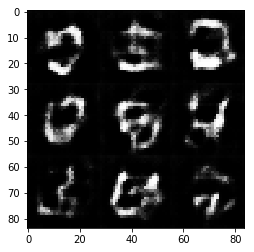

Epoch 1/2... Discriminator Loss: 1.3234... Generator Loss: 1.4999
Epoch 1/2... Discriminator Loss: 1.5174... Generator Loss: 1.4489
Epoch 1/2... Discriminator Loss: 1.5890... Generator Loss: 1.9209
Epoch 1/2... Discriminator Loss: 1.4325... Generator Loss: 1.5356
Epoch 1/2... Discriminator Loss: 1.4357... Generator Loss: 1.5980
Epoch 1/2... Discriminator Loss: 1.3590... Generator Loss: 1.5373
Epoch 1/2... Discriminator Loss: 1.2341... Generator Loss: 1.3764
Epoch 1/2... Discriminator Loss: 1.3320... Generator Loss: 1.2704
Epoch 1/2... Discriminator Loss: 1.4896... Generator Loss: 1.6212
Epoch 1/2... Discriminator Loss: 1.1796... Generator Loss: 1.2375


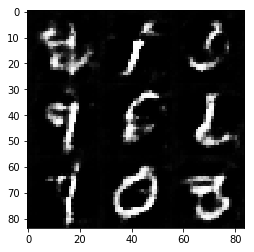

Epoch 1/2... Discriminator Loss: 1.1144... Generator Loss: 1.2617
Epoch 1/2... Discriminator Loss: 1.5544... Generator Loss: 0.3436
Epoch 1/2... Discriminator Loss: 1.5770... Generator Loss: 0.3355
Epoch 1/2... Discriminator Loss: 1.0502... Generator Loss: 0.7508
Epoch 1/2... Discriminator Loss: 1.9080... Generator Loss: 0.2253
Epoch 1/2... Discriminator Loss: 1.4979... Generator Loss: 0.3433
Epoch 1/2... Discriminator Loss: 1.3935... Generator Loss: 0.4131
Epoch 1/2... Discriminator Loss: 1.7946... Generator Loss: 0.2347
Epoch 1/2... Discriminator Loss: 1.3211... Generator Loss: 0.4608
Epoch 1/2... Discriminator Loss: 1.1487... Generator Loss: 0.6400


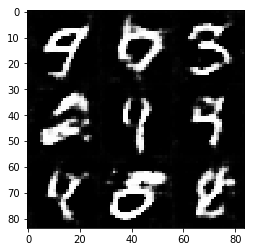

Epoch 1/2... Discriminator Loss: 1.3637... Generator Loss: 1.5209
Epoch 1/2... Discriminator Loss: 1.3150... Generator Loss: 1.4456
Epoch 1/2... Discriminator Loss: 1.3709... Generator Loss: 1.4043
Epoch 1/2... Discriminator Loss: 1.1501... Generator Loss: 1.2862
Epoch 1/2... Discriminator Loss: 1.1928... Generator Loss: 1.4482
Epoch 1/2... Discriminator Loss: 1.2266... Generator Loss: 1.3634
Epoch 1/2... Discriminator Loss: 1.0332... Generator Loss: 1.5329
Epoch 1/2... Discriminator Loss: 1.3415... Generator Loss: 0.8119
Epoch 1/2... Discriminator Loss: 1.1949... Generator Loss: 1.6969
Epoch 1/2... Discriminator Loss: 1.0565... Generator Loss: 1.4214


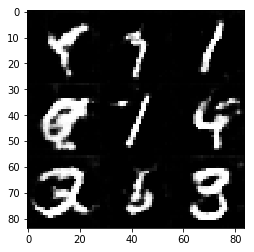

Epoch 1/2... Discriminator Loss: 1.2342... Generator Loss: 1.7267
Epoch 1/2... Discriminator Loss: 1.1725... Generator Loss: 1.3980
Epoch 1/2... Discriminator Loss: 0.9926... Generator Loss: 0.7642
Epoch 1/2... Discriminator Loss: 4.0475... Generator Loss: 4.4055
Epoch 1/2... Discriminator Loss: 1.1409... Generator Loss: 1.1952
Epoch 1/2... Discriminator Loss: 1.2124... Generator Loss: 1.0581
Epoch 1/2... Discriminator Loss: 1.2947... Generator Loss: 1.9422
Epoch 1/2... Discriminator Loss: 3.1457... Generator Loss: 3.4120
Epoch 1/2... Discriminator Loss: 1.1597... Generator Loss: 1.7960
Epoch 1/2... Discriminator Loss: 1.0667... Generator Loss: 0.8214


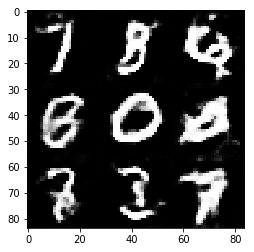

Epoch 1/2... Discriminator Loss: 1.0799... Generator Loss: 1.3758
Epoch 1/2... Discriminator Loss: 1.4718... Generator Loss: 2.3066
Epoch 1/2... Discriminator Loss: 1.3096... Generator Loss: 1.7531
Epoch 1/2... Discriminator Loss: 1.0767... Generator Loss: 1.0265
Epoch 1/2... Discriminator Loss: 1.1240... Generator Loss: 1.0241
Epoch 1/2... Discriminator Loss: 2.0521... Generator Loss: 0.3226
Epoch 1/2... Discriminator Loss: 1.5854... Generator Loss: 0.3328
Epoch 1/2... Discriminator Loss: 2.1025... Generator Loss: 0.1848
Epoch 1/2... Discriminator Loss: 1.0142... Generator Loss: 1.3598
Epoch 1/2... Discriminator Loss: 1.2161... Generator Loss: 1.3768


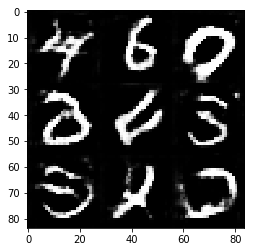

Epoch 1/2... Discriminator Loss: 1.6667... Generator Loss: 2.4289
Epoch 1/2... Discriminator Loss: 1.6060... Generator Loss: 0.3035
Epoch 1/2... Discriminator Loss: 1.2408... Generator Loss: 0.5558
Epoch 1/2... Discriminator Loss: 1.5556... Generator Loss: 0.3371
Epoch 1/2... Discriminator Loss: 1.5295... Generator Loss: 0.3262
Epoch 1/2... Discriminator Loss: 1.3208... Generator Loss: 0.4276
Epoch 1/2... Discriminator Loss: 0.9875... Generator Loss: 0.7280
Epoch 1/2... Discriminator Loss: 1.7180... Generator Loss: 0.2622
Epoch 1/2... Discriminator Loss: 0.9655... Generator Loss: 0.7302
Epoch 1/2... Discriminator Loss: 1.7267... Generator Loss: 0.3268


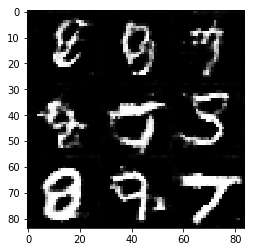

Epoch 1/2... Discriminator Loss: 1.2644... Generator Loss: 0.7011
Epoch 1/2... Discriminator Loss: 1.1188... Generator Loss: 1.5761
Epoch 1/2... Discriminator Loss: 1.1952... Generator Loss: 0.5103
Epoch 1/2... Discriminator Loss: 0.7791... Generator Loss: 0.9350
Epoch 1/2... Discriminator Loss: 2.2790... Generator Loss: 0.1648
Epoch 1/2... Discriminator Loss: 1.5151... Generator Loss: 0.4486
Epoch 1/2... Discriminator Loss: 1.8694... Generator Loss: 0.2257
Epoch 1/2... Discriminator Loss: 1.0994... Generator Loss: 0.6510
Epoch 1/2... Discriminator Loss: 1.4656... Generator Loss: 0.3648
Epoch 1/2... Discriminator Loss: 1.2120... Generator Loss: 0.5249


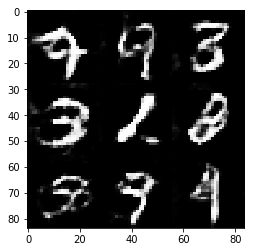

Epoch 1/2... Discriminator Loss: 1.7630... Generator Loss: 0.2861
Epoch 1/2... Discriminator Loss: 1.1659... Generator Loss: 0.5611
Epoch 1/2... Discriminator Loss: 1.2264... Generator Loss: 0.5115
Epoch 2/2... Discriminator Loss: 1.0377... Generator Loss: 1.8107
Epoch 2/2... Discriminator Loss: 1.0488... Generator Loss: 0.9030
Epoch 2/2... Discriminator Loss: 0.7052... Generator Loss: 1.3960
Epoch 2/2... Discriminator Loss: 6.0860... Generator Loss: 6.2421
Epoch 2/2... Discriminator Loss: 1.1198... Generator Loss: 0.7675
Epoch 2/2... Discriminator Loss: 0.9722... Generator Loss: 1.3065
Epoch 2/2... Discriminator Loss: 1.6883... Generator Loss: 0.2953


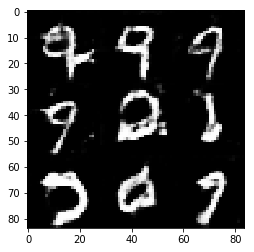

Epoch 2/2... Discriminator Loss: 1.5562... Generator Loss: 0.3388
Epoch 2/2... Discriminator Loss: 1.5142... Generator Loss: 0.3319
Epoch 2/2... Discriminator Loss: 1.0418... Generator Loss: 0.6821
Epoch 2/2... Discriminator Loss: 1.7074... Generator Loss: 0.3037
Epoch 2/2... Discriminator Loss: 1.9671... Generator Loss: 0.2043
Epoch 2/2... Discriminator Loss: 1.1558... Generator Loss: 0.5452
Epoch 2/2... Discriminator Loss: 0.8777... Generator Loss: 0.8369
Epoch 2/2... Discriminator Loss: 1.2018... Generator Loss: 2.8873
Epoch 2/2... Discriminator Loss: 0.8801... Generator Loss: 1.3967
Epoch 2/2... Discriminator Loss: 1.0647... Generator Loss: 0.6651


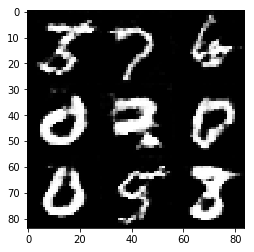

Epoch 2/2... Discriminator Loss: 2.4022... Generator Loss: 0.1367
Epoch 2/2... Discriminator Loss: 1.6354... Generator Loss: 2.5714
Epoch 2/2... Discriminator Loss: 1.4216... Generator Loss: 0.3861
Epoch 2/2... Discriminator Loss: 1.0635... Generator Loss: 0.6505
Epoch 2/2... Discriminator Loss: 0.8572... Generator Loss: 0.9409
Epoch 2/2... Discriminator Loss: 1.3399... Generator Loss: 1.9807
Epoch 2/2... Discriminator Loss: 2.0122... Generator Loss: 3.6991
Epoch 2/2... Discriminator Loss: 0.8873... Generator Loss: 1.3932
Epoch 2/2... Discriminator Loss: 1.2784... Generator Loss: 2.2925
Epoch 2/2... Discriminator Loss: 0.6704... Generator Loss: 1.6810


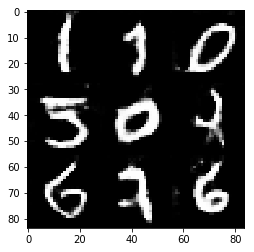

Epoch 2/2... Discriminator Loss: 1.4597... Generator Loss: 0.3874
Epoch 2/2... Discriminator Loss: 0.6003... Generator Loss: 1.6830
Epoch 2/2... Discriminator Loss: 1.7706... Generator Loss: 2.3009
Epoch 2/2... Discriminator Loss: 0.8414... Generator Loss: 1.5103
Epoch 2/2... Discriminator Loss: 4.0684... Generator Loss: 4.8978
Epoch 2/2... Discriminator Loss: 1.1622... Generator Loss: 0.7651
Epoch 2/2... Discriminator Loss: 0.8814... Generator Loss: 1.0979
Epoch 2/2... Discriminator Loss: 1.3765... Generator Loss: 0.4216
Epoch 2/2... Discriminator Loss: 0.7652... Generator Loss: 0.9604
Epoch 2/2... Discriminator Loss: 3.0510... Generator Loss: 4.7352


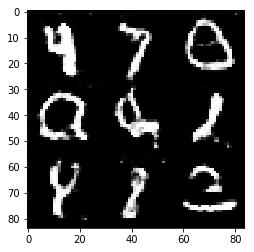

Epoch 2/2... Discriminator Loss: 0.8066... Generator Loss: 1.2812
Epoch 2/2... Discriminator Loss: 0.8733... Generator Loss: 1.6515
Epoch 2/2... Discriminator Loss: 0.8763... Generator Loss: 1.9005
Epoch 2/2... Discriminator Loss: 0.8034... Generator Loss: 1.4711
Epoch 2/2... Discriminator Loss: 0.4599... Generator Loss: 1.5672
Epoch 2/2... Discriminator Loss: 2.6650... Generator Loss: 0.1034
Epoch 2/2... Discriminator Loss: 1.3878... Generator Loss: 2.3881
Epoch 2/2... Discriminator Loss: 0.9809... Generator Loss: 0.8397
Epoch 2/2... Discriminator Loss: 0.7555... Generator Loss: 1.0976
Epoch 2/2... Discriminator Loss: 3.5568... Generator Loss: 5.2918


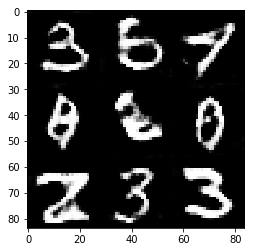

Epoch 2/2... Discriminator Loss: 0.9704... Generator Loss: 1.9051
Epoch 2/2... Discriminator Loss: 1.0579... Generator Loss: 0.6915
Epoch 2/2... Discriminator Loss: 0.8514... Generator Loss: 0.8721
Epoch 2/2... Discriminator Loss: 0.9024... Generator Loss: 0.8395
Epoch 2/2... Discriminator Loss: 1.2792... Generator Loss: 0.5090
Epoch 2/2... Discriminator Loss: 0.7570... Generator Loss: 1.2142
Epoch 2/2... Discriminator Loss: 0.7682... Generator Loss: 2.2858
Epoch 2/2... Discriminator Loss: 0.7398... Generator Loss: 1.5228
Epoch 2/2... Discriminator Loss: 1.1285... Generator Loss: 0.5570
Epoch 2/2... Discriminator Loss: 0.7004... Generator Loss: 1.0168


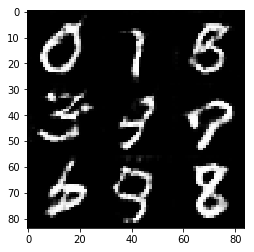

Epoch 2/2... Discriminator Loss: 0.8460... Generator Loss: 1.1806
Epoch 2/2... Discriminator Loss: 1.5888... Generator Loss: 0.3907
Epoch 2/2... Discriminator Loss: 0.8099... Generator Loss: 0.8961
Epoch 2/2... Discriminator Loss: 4.6878... Generator Loss: 5.4881
Epoch 2/2... Discriminator Loss: 1.2074... Generator Loss: 0.7320
Epoch 2/2... Discriminator Loss: 1.1128... Generator Loss: 0.5773
Epoch 2/2... Discriminator Loss: 0.6911... Generator Loss: 1.2798
Epoch 2/2... Discriminator Loss: 0.8471... Generator Loss: 1.1875
Epoch 2/2... Discriminator Loss: 0.9292... Generator Loss: 0.9940
Epoch 2/2... Discriminator Loss: 1.5543... Generator Loss: 0.3651


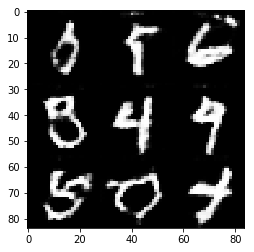

Epoch 2/2... Discriminator Loss: 0.5579... Generator Loss: 1.5678
Epoch 2/2... Discriminator Loss: 1.5414... Generator Loss: 2.7286
Epoch 2/2... Discriminator Loss: 0.8668... Generator Loss: 0.8036
Epoch 2/2... Discriminator Loss: 1.7511... Generator Loss: 0.2794
Epoch 2/2... Discriminator Loss: 1.0786... Generator Loss: 0.7043
Epoch 2/2... Discriminator Loss: 1.1724... Generator Loss: 0.5497
Epoch 2/2... Discriminator Loss: 0.8742... Generator Loss: 0.7681
Epoch 2/2... Discriminator Loss: 2.1646... Generator Loss: 0.1800
Epoch 2/2... Discriminator Loss: 0.7900... Generator Loss: 1.0164
Epoch 2/2... Discriminator Loss: 0.9523... Generator Loss: 2.5983


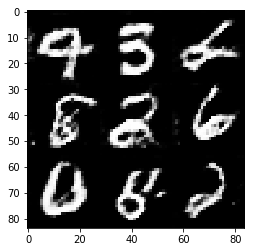

Epoch 2/2... Discriminator Loss: 1.8579... Generator Loss: 0.2546
Epoch 2/2... Discriminator Loss: 1.0179... Generator Loss: 1.0738
Epoch 2/2... Discriminator Loss: 2.7409... Generator Loss: 0.1453
Epoch 2/2... Discriminator Loss: 0.7853... Generator Loss: 1.6259
Epoch 2/2... Discriminator Loss: 1.6919... Generator Loss: 0.3913
Epoch 2/2... Discriminator Loss: 0.8468... Generator Loss: 0.8666
Epoch 2/2... Discriminator Loss: 2.6401... Generator Loss: 4.0918
Epoch 2/2... Discriminator Loss: 1.4574... Generator Loss: 0.3722
Epoch 2/2... Discriminator Loss: 0.4387... Generator Loss: 2.2603
Epoch 2/2... Discriminator Loss: 1.4253... Generator Loss: 0.4557


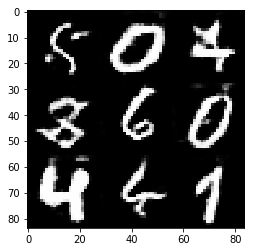

Epoch 2/2... Discriminator Loss: 1.2468... Generator Loss: 0.5482
Epoch 2/2... Discriminator Loss: 1.0073... Generator Loss: 0.7063
Epoch 2/2... Discriminator Loss: 0.4523... Generator Loss: 3.0096
Epoch 2/2... Discriminator Loss: 1.1944... Generator Loss: 2.1281
Epoch 2/2... Discriminator Loss: 1.2268... Generator Loss: 0.6883
Epoch 2/2... Discriminator Loss: 0.7264... Generator Loss: 1.1729
Epoch 2/2... Discriminator Loss: 1.6443... Generator Loss: 0.4127


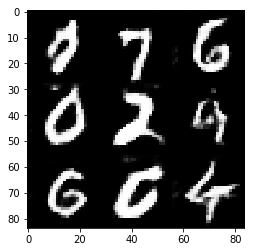

In [38]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.6646... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.9057... Generator Loss: 19.3048
Epoch 1/1... Discriminator Loss: 2.2001... Generator Loss: 1.9568
Epoch 1/1... Discriminator Loss: 2.3041... Generator Loss: 0.9576
Epoch 1/1... Discriminator Loss: 0.0288... Generator Loss: 5.4687
Epoch 1/1... Discriminator Loss: 0.7254... Generator Loss: 2.8299
Epoch 1/1... Discriminator Loss: 0.4975... Generator Loss: 2.0202
Epoch 1/1... Discriminator Loss: 2.1822... Generator Loss: 2.2522
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 1.2140
Epoch 1/1... Discriminator Loss: 1.6128... Generator Loss: 6.5080


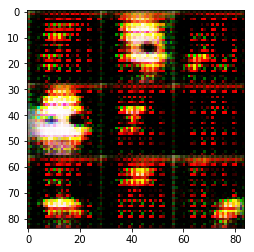

Epoch 1/1... Discriminator Loss: 2.6822... Generator Loss: 0.1303
Epoch 1/1... Discriminator Loss: 1.5288... Generator Loss: 0.4475
Epoch 1/1... Discriminator Loss: 0.9715... Generator Loss: 1.1977
Epoch 1/1... Discriminator Loss: 0.4304... Generator Loss: 1.7382
Epoch 1/1... Discriminator Loss: 0.2400... Generator Loss: 1.7005
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 0.5839
Epoch 1/1... Discriminator Loss: 2.3526... Generator Loss: 0.2381
Epoch 1/1... Discriminator Loss: 0.0100... Generator Loss: 5.1683
Epoch 1/1... Discriminator Loss: 0.0978... Generator Loss: 5.2602
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 1.0120


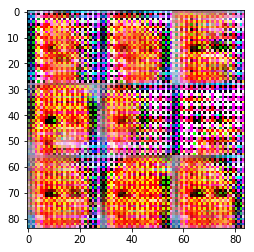

Epoch 1/1... Discriminator Loss: 0.1137... Generator Loss: 2.6553
Epoch 1/1... Discriminator Loss: 0.1567... Generator Loss: 3.0257
Epoch 1/1... Discriminator Loss: 2.0778... Generator Loss: 0.3532
Epoch 1/1... Discriminator Loss: 0.6382... Generator Loss: 1.8710
Epoch 1/1... Discriminator Loss: 0.3549... Generator Loss: 2.2102
Epoch 1/1... Discriminator Loss: 0.5290... Generator Loss: 2.7317
Epoch 1/1... Discriminator Loss: 0.7506... Generator Loss: 1.1063
Epoch 1/1... Discriminator Loss: 0.0818... Generator Loss: 4.1096
Epoch 1/1... Discriminator Loss: 0.0917... Generator Loss: 3.6285
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.7604


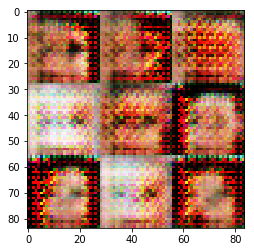

Epoch 1/1... Discriminator Loss: 1.5961... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 0.9838
Epoch 1/1... Discriminator Loss: 0.5512... Generator Loss: 1.5144
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.4110
Epoch 1/1... Discriminator Loss: 0.6711... Generator Loss: 1.1811
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 1.6247
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 3.6090
Epoch 1/1... Discriminator Loss: 0.7026... Generator Loss: 1.3271
Epoch 1/1... Discriminator Loss: 1.7033... Generator Loss: 0.5092


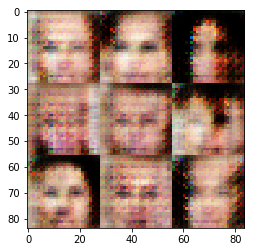

Epoch 1/1... Discriminator Loss: 2.3569... Generator Loss: 0.3222
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 1.1108
Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 1.3533
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 1.1286
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 1.8588
Epoch 1/1... Discriminator Loss: 0.8703... Generator Loss: 1.6697
Epoch 1/1... Discriminator Loss: 0.9856... Generator Loss: 1.6553
Epoch 1/1... Discriminator Loss: 4.4901... Generator Loss: 3.6975
Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 0.7651... Generator Loss: 1.4845


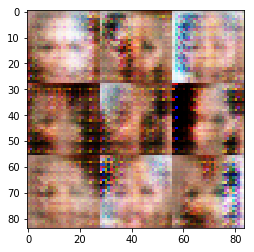

Epoch 1/1... Discriminator Loss: 1.9547... Generator Loss: 1.2612
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 0.8545... Generator Loss: 1.2487
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 0.8076... Generator Loss: 1.0965
Epoch 1/1... Discriminator Loss: 1.9442... Generator Loss: 0.2939
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.4521
Epoch 1/1... Discriminator Loss: 1.0496... Generator Loss: 0.9895


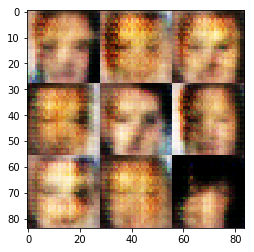

Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.7488... Generator Loss: 0.9456
Epoch 1/1... Discriminator Loss: 0.9758... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 2.6536... Generator Loss: 2.3151
Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 1.1355
Epoch 1/1... Discriminator Loss: 2.0975... Generator Loss: 0.2457
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 1.3875
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.4365
Epoch 1/1... Discriminator Loss: 0.8529... Generator Loss: 0.9324


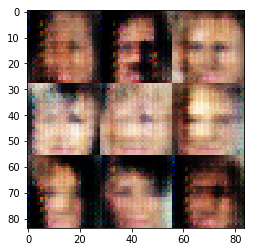

Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 2.4801
Epoch 1/1... Discriminator Loss: 0.6799... Generator Loss: 1.3321
Epoch 1/1... Discriminator Loss: 0.5179... Generator Loss: 1.2627
Epoch 1/1... Discriminator Loss: 1.5712... Generator Loss: 0.3823
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.4233
Epoch 1/1... Discriminator Loss: 0.8917... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 0.8929... Generator Loss: 2.0455
Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 0.5724
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.0173... Generator Loss: 0.6860


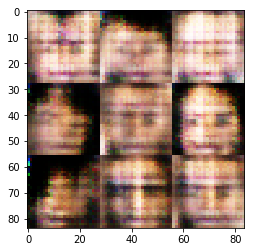

Epoch 1/1... Discriminator Loss: 0.6909... Generator Loss: 2.9395
Epoch 1/1... Discriminator Loss: 0.5039... Generator Loss: 1.6381
Epoch 1/1... Discriminator Loss: 0.9719... Generator Loss: 1.0306
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 0.5545
Epoch 1/1... Discriminator Loss: 0.8127... Generator Loss: 0.7454
Epoch 1/1... Discriminator Loss: 0.7117... Generator Loss: 1.6514
Epoch 1/1... Discriminator Loss: 1.7133... Generator Loss: 0.3356
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 1.2269
Epoch 1/1... Discriminator Loss: 0.6680... Generator Loss: 0.8962
Epoch 1/1... Discriminator Loss: 0.7704... Generator Loss: 1.1919


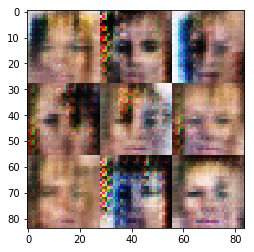

Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.9357
Epoch 1/1... Discriminator Loss: 1.0391... Generator Loss: 1.1268
Epoch 1/1... Discriminator Loss: 0.8535... Generator Loss: 1.0914
Epoch 1/1... Discriminator Loss: 0.8870... Generator Loss: 1.3255
Epoch 1/1... Discriminator Loss: 0.9670... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 0.7643... Generator Loss: 0.8466
Epoch 1/1... Discriminator Loss: 2.1018... Generator Loss: 3.0447
Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 1.9481
Epoch 1/1... Discriminator Loss: 0.9499... Generator Loss: 1.0853
Epoch 1/1... Discriminator Loss: 0.8461... Generator Loss: 1.1367


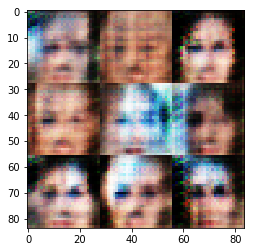

Epoch 1/1... Discriminator Loss: 2.0500... Generator Loss: 0.2374
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 1.1074
Epoch 1/1... Discriminator Loss: 0.6148... Generator Loss: 1.4476
Epoch 1/1... Discriminator Loss: 0.6409... Generator Loss: 1.3861
Epoch 1/1... Discriminator Loss: 1.0675... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 0.5566... Generator Loss: 1.4210
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.0092... Generator Loss: 1.1410
Epoch 1/1... Discriminator Loss: 0.9900... Generator Loss: 0.7055


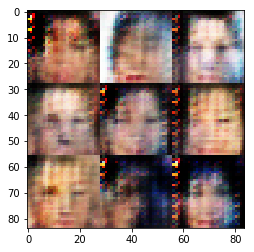

Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.4309
Epoch 1/1... Discriminator Loss: 0.8809... Generator Loss: 1.4155
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 2.7264
Epoch 1/1... Discriminator Loss: 1.0465... Generator Loss: 0.6141
Epoch 1/1... Discriminator Loss: 0.5263... Generator Loss: 2.6454
Epoch 1/1... Discriminator Loss: 0.5947... Generator Loss: 1.2771
Epoch 1/1... Discriminator Loss: 0.5827... Generator Loss: 1.1765
Epoch 1/1... Discriminator Loss: 1.0350... Generator Loss: 1.5182
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.5396
Epoch 1/1... Discriminator Loss: 0.7044... Generator Loss: 1.2342


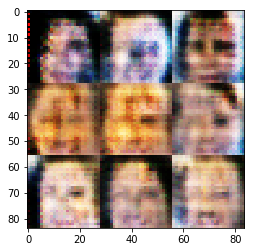

Epoch 1/1... Discriminator Loss: 0.9762... Generator Loss: 2.0690
Epoch 1/1... Discriminator Loss: 0.2796... Generator Loss: 2.1792
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 1.1250
Epoch 1/1... Discriminator Loss: 1.5815... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 1.1669
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 1.1412


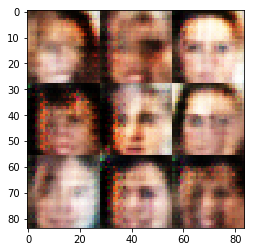

Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 0.8321... Generator Loss: 0.9900
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 0.9950... Generator Loss: 1.1560
Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.5207
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.5961
Epoch 1/1... Discriminator Loss: 1.0207... Generator Loss: 1.1776
Epoch 1/1... Discriminator Loss: 0.8770... Generator Loss: 1.3094


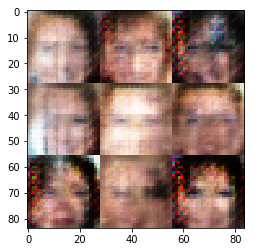

Epoch 1/1... Discriminator Loss: 1.0455... Generator Loss: 0.6033
Epoch 1/1... Discriminator Loss: 0.5231... Generator Loss: 1.5129
Epoch 1/1... Discriminator Loss: 0.7445... Generator Loss: 1.3386
Epoch 1/1... Discriminator Loss: 1.7667... Generator Loss: 0.2914
Epoch 1/1... Discriminator Loss: 0.6082... Generator Loss: 1.0730
Epoch 1/1... Discriminator Loss: 2.7897... Generator Loss: 0.0924
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.9571
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 0.9196
Epoch 1/1... Discriminator Loss: 1.0636... Generator Loss: 1.0413


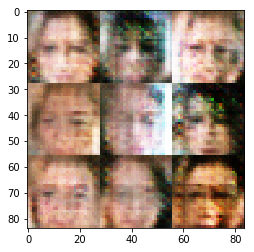

Epoch 1/1... Discriminator Loss: 0.9014... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 1.0492
Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 0.4951
Epoch 1/1... Discriminator Loss: 0.9860... Generator Loss: 1.7307
Epoch 1/1... Discriminator Loss: 0.5903... Generator Loss: 1.1219
Epoch 1/1... Discriminator Loss: 2.0055... Generator Loss: 0.4208
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 1.0501
Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 0.9916... Generator Loss: 1.3566
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.5404


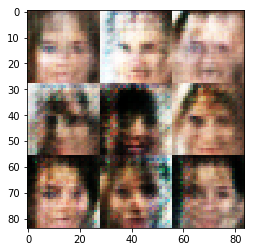

Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 1.1287... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 1.0200
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 0.8178... Generator Loss: 1.2469
Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.0197... Generator Loss: 1.0250
Epoch 1/1... Discriminator Loss: 1.5254... Generator Loss: 0.6462


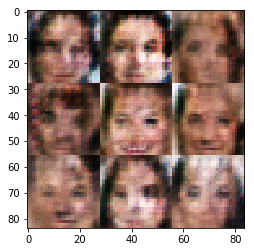

Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 1.2928
Epoch 1/1... Discriminator Loss: 1.0852... Generator Loss: 0.9528
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 0.5112
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.5302
Epoch 1/1... Discriminator Loss: 2.2024... Generator Loss: 1.6634
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 0.7603


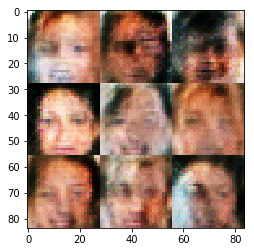

Epoch 1/1... Discriminator Loss: 0.8964... Generator Loss: 0.9986
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 1.1911
Epoch 1/1... Discriminator Loss: 1.5674... Generator Loss: 0.3518
Epoch 1/1... Discriminator Loss: 0.9385... Generator Loss: 0.9038
Epoch 1/1... Discriminator Loss: 0.9167... Generator Loss: 1.4533
Epoch 1/1... Discriminator Loss: 0.8364... Generator Loss: 1.0496
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 1.0629
Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 1.2238
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 1.4936


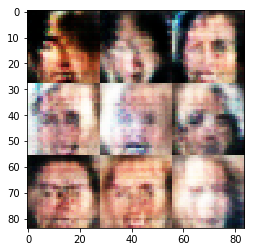

Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 1.3640
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.5695... Generator Loss: 0.5811
Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 2.4028... Generator Loss: 0.1255
Epoch 1/1... Discriminator Loss: 2.1649... Generator Loss: 1.8321
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.5568
Epoch 1/1... Discriminator Loss: 0.5067... Generator Loss: 1.2848
Epoch 1/1... Discriminator Loss: 4.7261... Generator Loss: 3.5228


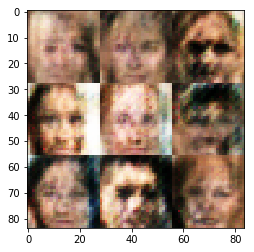

Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 0.5217
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 1.0037
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 1.1351
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.4217
Epoch 1/1... Discriminator Loss: 0.5355... Generator Loss: 1.4902
Epoch 1/1... Discriminator Loss: 1.2872... Generator Loss: 1.2183
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 1.9428
Epoch 1/1... Discriminator Loss: 0.8617... Generator Loss: 0.9658
Epoch 1/1... Discriminator Loss: 0.5930... Generator Loss: 1.3954
Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 0.7677


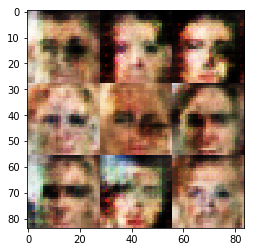

Epoch 1/1... Discriminator Loss: 0.8828... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 0.7215... Generator Loss: 2.4454
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.4484
Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 1.7172
Epoch 1/1... Discriminator Loss: 1.0813... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.0060... Generator Loss: 1.8986
Epoch 1/1... Discriminator Loss: 0.9915... Generator Loss: 1.3158
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.4611
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.3808


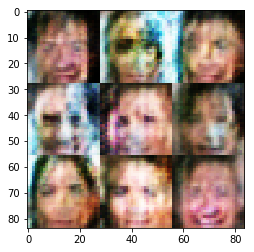

Epoch 1/1... Discriminator Loss: 0.7243... Generator Loss: 1.9292
Epoch 1/1... Discriminator Loss: 1.6123... Generator Loss: 0.3810
Epoch 1/1... Discriminator Loss: 1.5083... Generator Loss: 1.1708
Epoch 1/1... Discriminator Loss: 0.7135... Generator Loss: 1.3483
Epoch 1/1... Discriminator Loss: 0.6014... Generator Loss: 1.2072
Epoch 1/1... Discriminator Loss: 0.3237... Generator Loss: 2.0112
Epoch 1/1... Discriminator Loss: 3.3029... Generator Loss: 4.5550
Epoch 1/1... Discriminator Loss: 0.6030... Generator Loss: 2.2151
Epoch 1/1... Discriminator Loss: 0.4916... Generator Loss: 1.4384
Epoch 1/1... Discriminator Loss: 1.6461... Generator Loss: 2.7057


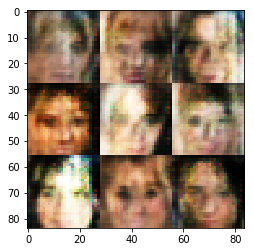

Epoch 1/1... Discriminator Loss: 2.9558... Generator Loss: 3.4341
Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 1.0240... Generator Loss: 0.9463
Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 1.0331
Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 0.8436
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 0.9344
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 0.8270


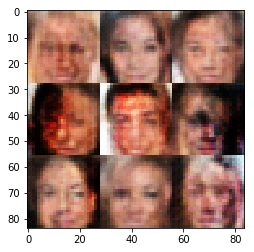

Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.0860... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 1.0520
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 0.9163
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 1.0908
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 0.9893
Epoch 1/1... Discriminator Loss: 0.9267... Generator Loss: 0.9975
Epoch 1/1... Discriminator Loss: 0.8529... Generator Loss: 0.7944


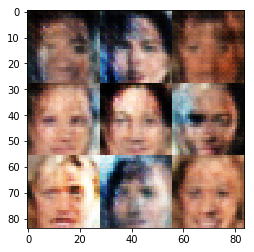

Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 1.0881
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 1.0132
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 0.9166
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.9602
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 0.9705... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.1429... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.4627
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.5798


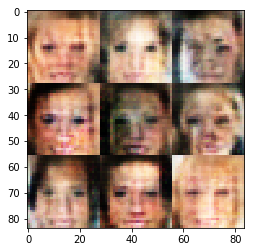

Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.5538
Epoch 1/1... Discriminator Loss: 0.7973... Generator Loss: 0.9708
Epoch 1/1... Discriminator Loss: 1.0505... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.0408... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 0.9892... Generator Loss: 0.9015
Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 1.0069
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 0.4757
Epoch 1/1... Discriminator Loss: 0.8104... Generator Loss: 1.2206
Epoch 1/1... Discriminator Loss: 0.9773... Generator Loss: 0.6340


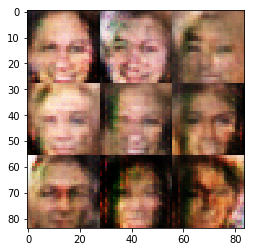

Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 1.0079
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 1.5082
Epoch 1/1... Discriminator Loss: 1.0093... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 1.0215
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 0.9640
Epoch 1/1... Discriminator Loss: 1.6729... Generator Loss: 0.3223
Epoch 1/1... Discriminator Loss: 0.7870... Generator Loss: 1.2188
Epoch 1/1... Discriminator Loss: 0.6257... Generator Loss: 0.8788
Epoch 1/1... Discriminator Loss: 0.8240... Generator Loss: 1.4182
Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 0.5060


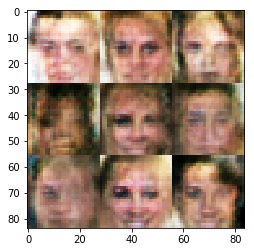

Epoch 1/1... Discriminator Loss: 0.9500... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 0.6094... Generator Loss: 1.2391
Epoch 1/1... Discriminator Loss: 0.5963... Generator Loss: 0.9924
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.4407
Epoch 1/1... Discriminator Loss: 1.9863... Generator Loss: 0.3818
Epoch 1/1... Discriminator Loss: 0.9467... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 0.9799... Generator Loss: 1.0525
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.9355
Epoch 1/1... Discriminator Loss: 0.9888... Generator Loss: 1.0696
Epoch 1/1... Discriminator Loss: 0.8142... Generator Loss: 1.1051


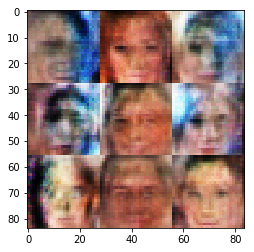

Epoch 1/1... Discriminator Loss: 1.0570... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 0.8419... Generator Loss: 1.1836
Epoch 1/1... Discriminator Loss: 0.6252... Generator Loss: 0.9613
Epoch 1/1... Discriminator Loss: 0.4677... Generator Loss: 1.3143
Epoch 1/1... Discriminator Loss: 0.6233... Generator Loss: 1.0051
Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 0.7963... Generator Loss: 1.0019
Epoch 1/1... Discriminator Loss: 1.0138... Generator Loss: 0.9856
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.5005


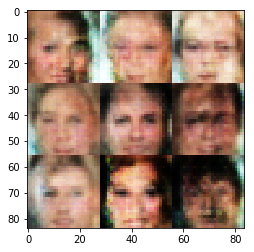

Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 0.9452... Generator Loss: 1.0215
Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 0.9329... Generator Loss: 0.9266
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.5612
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 0.8292
Epoch 1/1... Discriminator Loss: 0.9504... Generator Loss: 0.8792
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 0.5068
Epoch 1/1... Discriminator Loss: 0.7634... Generator Loss: 0.7979


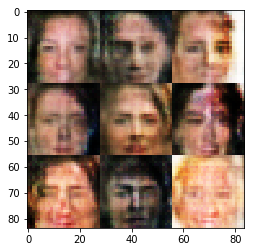

Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.5038
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 0.5683... Generator Loss: 1.4023
Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 1.5252
Epoch 1/1... Discriminator Loss: 0.4641... Generator Loss: 1.5775
Epoch 1/1... Discriminator Loss: 0.7774... Generator Loss: 1.1370
Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 0.8922... Generator Loss: 1.2514
Epoch 1/1... Discriminator Loss: 1.0996... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 0.6047


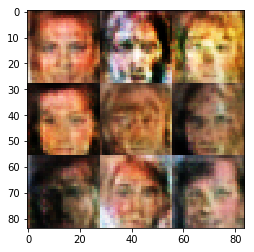

Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 1.1886
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.5754
Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 1.0240... Generator Loss: 1.0924
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 0.9968... Generator Loss: 0.8771
Epoch 1/1... Discriminator Loss: 0.9492... Generator Loss: 0.8776


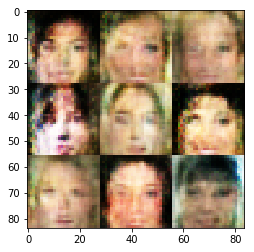

Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 0.9072... Generator Loss: 0.9887
Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 1.3404
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 0.9159... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 0.9274... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.2338... Generator Loss: 1.1893
Epoch 1/1... Discriminator Loss: 0.9033... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.5410


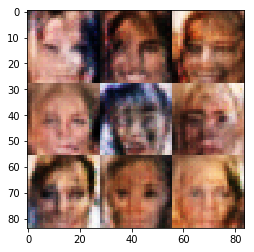

Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.1056... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 0.9694
Epoch 1/1... Discriminator Loss: 1.0923... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.4791
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 1.6840
Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 0.8595
Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.4160
Epoch 1/1... Discriminator Loss: 0.5602... Generator Loss: 1.6261
Epoch 1/1... Discriminator Loss: 0.9674... Generator Loss: 1.0977


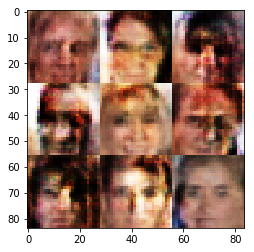

Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.4640
Epoch 1/1... Discriminator Loss: 1.1192... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 0.9326... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.5100
Epoch 1/1... Discriminator Loss: 0.9773... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 0.8479... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.4918... Generator Loss: 0.3989
Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 0.9464... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.1373... Generator Loss: 0.4719


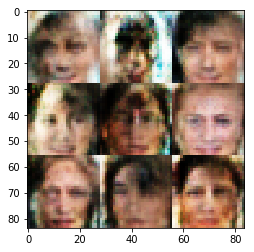

Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 1.1187
Epoch 1/1... Discriminator Loss: 0.5379... Generator Loss: 1.1109
Epoch 1/1... Discriminator Loss: 1.6502... Generator Loss: 0.3313
Epoch 1/1... Discriminator Loss: 0.6260... Generator Loss: 1.5767
Epoch 1/1... Discriminator Loss: 0.6106... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 0.5937
Epoch 1/1... Discriminator Loss: 1.5685... Generator Loss: 0.5111
Epoch 1/1... Discriminator Loss: 0.6004... Generator Loss: 1.0547
Epoch 1/1... Discriminator Loss: 0.3162... Generator Loss: 2.2223
Epoch 1/1... Discriminator Loss: 0.5889... Generator Loss: 1.2203


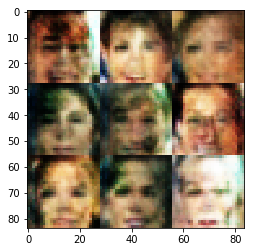

Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.8684
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 0.5864
Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 1.0582... Generator Loss: 0.9144
Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 1.0720... Generator Loss: 0.9016
Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 0.7179


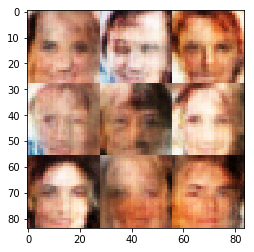

Epoch 1/1... Discriminator Loss: 1.0147... Generator Loss: 0.6132
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.3995
Epoch 1/1... Discriminator Loss: 0.3491... Generator Loss: 1.6889
Epoch 1/1... Discriminator Loss: 1.6628... Generator Loss: 0.3189
Epoch 1/1... Discriminator Loss: 0.9026... Generator Loss: 0.9875
Epoch 1/1... Discriminator Loss: 0.8222... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.5563
Epoch 1/1... Discriminator Loss: 0.8835... Generator Loss: 1.0614
Epoch 1/1... Discriminator Loss: 0.9823... Generator Loss: 0.9582


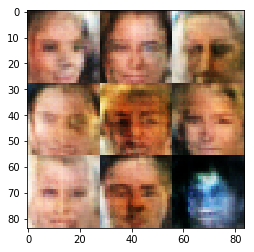

Epoch 1/1... Discriminator Loss: 0.8629... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 1.0246
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 1.1763
Epoch 1/1... Discriminator Loss: 0.9130... Generator Loss: 1.1587
Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 1.0611
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 0.9230
Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.1534... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 0.9819... Generator Loss: 1.0379
Epoch 1/1... Discriminator Loss: 0.9993... Generator Loss: 0.9248


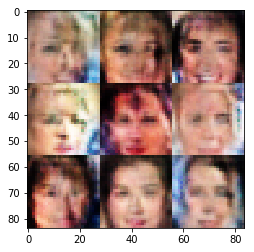

Epoch 1/1... Discriminator Loss: 1.0829... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.0742... Generator Loss: 1.0794
Epoch 1/1... Discriminator Loss: 0.8151... Generator Loss: 1.0696
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.5593
Epoch 1/1... Discriminator Loss: 1.0052... Generator Loss: 0.9144
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.6104
Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 0.8326... Generator Loss: 1.0323
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 0.9865
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 0.9977


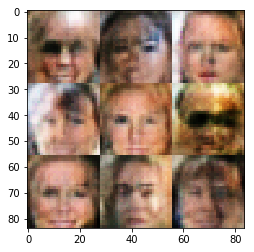

Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 1.2199
Epoch 1/1... Discriminator Loss: 0.8251... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 0.5758
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.5279
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.9032
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 1.1804
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 0.9096... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 0.9095... Generator Loss: 0.8145


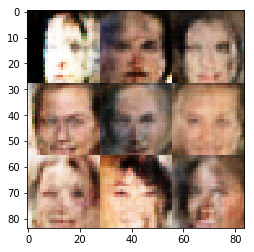

Epoch 1/1... Discriminator Loss: 1.5495... Generator Loss: 0.4537
Epoch 1/1... Discriminator Loss: 0.9166... Generator Loss: 1.2188
Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.5497
Epoch 1/1... Discriminator Loss: 1.9293... Generator Loss: 0.1874
Epoch 1/1... Discriminator Loss: 0.8872... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 0.7433... Generator Loss: 1.2604
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 1.3895
Epoch 1/1... Discriminator Loss: 1.1004... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 0.8040


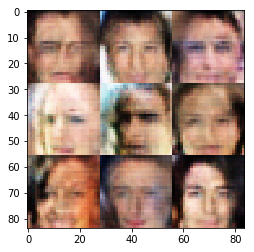

Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.0115... Generator Loss: 1.1652
Epoch 1/1... Discriminator Loss: 1.1255... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 0.9841... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.0062... Generator Loss: 0.8629
Epoch 1/1... Discriminator Loss: 0.9878... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 0.6994... Generator Loss: 1.1639


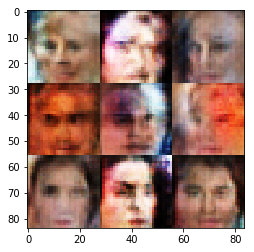

Epoch 1/1... Discriminator Loss: 1.0422... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.4032
Epoch 1/1... Discriminator Loss: 0.8793... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.4379
Epoch 1/1... Discriminator Loss: 1.0553... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 0.8764... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 0.5544
Epoch 1/1... Discriminator Loss: 1.0274... Generator Loss: 1.0341
Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 0.5242


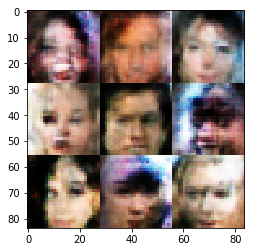

Epoch 1/1... Discriminator Loss: 0.7692... Generator Loss: 0.9684
Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.5633... Generator Loss: 0.5607
Epoch 1/1... Discriminator Loss: 0.6769... Generator Loss: 1.0316
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.6784
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.5317


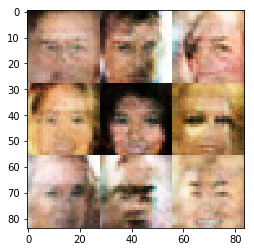

Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.0540... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.5520... Generator Loss: 0.4321
Epoch 1/1... Discriminator Loss: 0.6397... Generator Loss: 1.0908
Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 0.5166... Generator Loss: 2.0432
Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 1.3381
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.5227


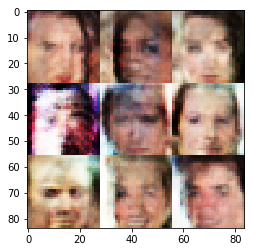

Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.4422
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.4930
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 0.5702
Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 0.8944
Epoch 1/1... Discriminator Loss: 1.0721... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 0.8936
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.5255
Epoch 1/1... Discriminator Loss: 0.9402... Generator Loss: 1.6628
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 0.9101


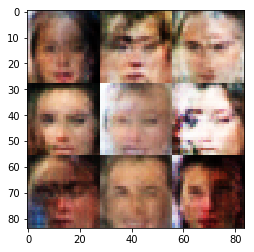

Epoch 1/1... Discriminator Loss: 0.6450... Generator Loss: 1.3187
Epoch 1/1... Discriminator Loss: 0.7015... Generator Loss: 0.9509
Epoch 1/1... Discriminator Loss: 1.6281... Generator Loss: 0.3179
Epoch 1/1... Discriminator Loss: 0.9799... Generator Loss: 0.9139
Epoch 1/1... Discriminator Loss: 1.5495... Generator Loss: 0.4872
Epoch 1/1... Discriminator Loss: 1.5139... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.9526
Epoch 1/1... Discriminator Loss: 1.0364... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 0.5902


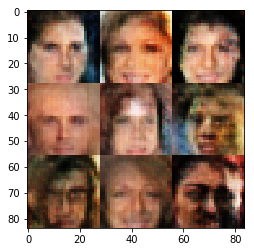

Epoch 1/1... Discriminator Loss: 0.8742... Generator Loss: 1.2453
Epoch 1/1... Discriminator Loss: 1.5103... Generator Loss: 0.3394
Epoch 1/1... Discriminator Loss: 0.8891... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 0.2363... Generator Loss: 1.9147
Epoch 1/1... Discriminator Loss: 0.8733... Generator Loss: 1.0851
Epoch 1/1... Discriminator Loss: 0.3591... Generator Loss: 1.5332
Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.3147
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 0.5096
Epoch 1/1... Discriminator Loss: 1.5064... Generator Loss: 0.3453
Epoch 1/1... Discriminator Loss: 0.7233... Generator Loss: 2.5659


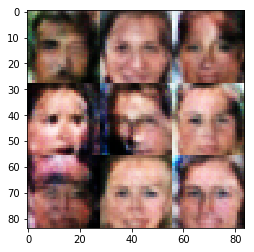

Epoch 1/1... Discriminator Loss: 0.3451... Generator Loss: 1.4920
Epoch 1/1... Discriminator Loss: 2.1172... Generator Loss: 2.6745
Epoch 1/1... Discriminator Loss: 0.8283... Generator Loss: 0.9736
Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 1.2352
Epoch 1/1... Discriminator Loss: 0.7871... Generator Loss: 1.4502
Epoch 1/1... Discriminator Loss: 0.8715... Generator Loss: 1.0848
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 0.1829... Generator Loss: 2.3564
Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 0.8765
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 0.6479


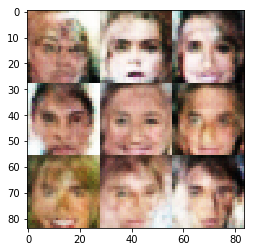

Epoch 1/1... Discriminator Loss: 0.8507... Generator Loss: 1.0520
Epoch 1/1... Discriminator Loss: 0.8544... Generator Loss: 1.0614
Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 0.9846
Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 0.9017
Epoch 1/1... Discriminator Loss: 1.0304... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.0106... Generator Loss: 0.6087
Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.4954
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.5662
Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 0.8974


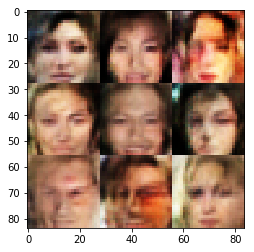

Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 0.4640
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 1.0953
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 1.0045... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.0112... Generator Loss: 1.0396
Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 0.8117


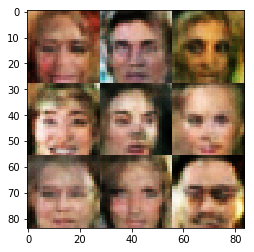

Epoch 1/1... Discriminator Loss: 0.9675... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 0.9830... Generator Loss: 0.9412
Epoch 1/1... Discriminator Loss: 0.8249... Generator Loss: 1.0032
Epoch 1/1... Discriminator Loss: 0.9138... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 1.3906
Epoch 1/1... Discriminator Loss: 0.8057... Generator Loss: 1.2838
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 0.9806


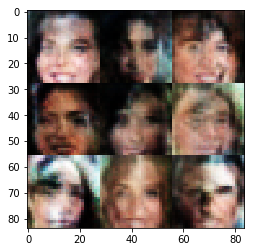

Epoch 1/1... Discriminator Loss: 0.9744... Generator Loss: 1.0103
Epoch 1/1... Discriminator Loss: 1.0777... Generator Loss: 1.0870
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 0.9614... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 0.8681
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.0072... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 0.5735
Epoch 1/1... Discriminator Loss: 1.0025... Generator Loss: 0.9125


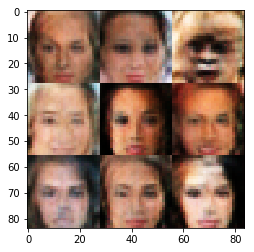

Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 1.1022... Generator Loss: 0.5935
Epoch 1/1... Discriminator Loss: 1.6980... Generator Loss: 0.3035
Epoch 1/1... Discriminator Loss: 0.7567... Generator Loss: 1.2781
Epoch 1/1... Discriminator Loss: 0.4098... Generator Loss: 1.1848
Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 2.6057
Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 0.1096... Generator Loss: 2.8483
Epoch 1/1... Discriminator Loss: 0.7502... Generator Loss: 0.8404
Epoch 1/1... Discriminator Loss: 0.8017... Generator Loss: 1.0186


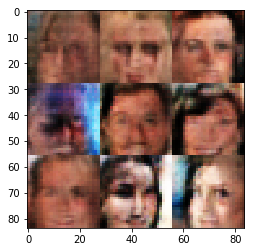

Epoch 1/1... Discriminator Loss: 1.6703... Generator Loss: 0.9773
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.4231
Epoch 1/1... Discriminator Loss: 0.5794... Generator Loss: 0.9563
Epoch 1/1... Discriminator Loss: 0.1927... Generator Loss: 3.5189
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.0378... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 0.8458... Generator Loss: 1.3754
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.6121
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.3497
Epoch 1/1... Discriminator Loss: 1.1205... Generator Loss: 0.8459


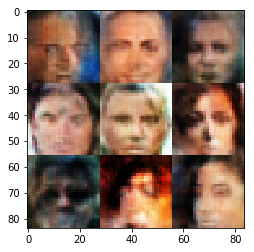

Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 0.4942
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.5407
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 0.9419
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 0.9459... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 0.5161
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.3984
Epoch 1/1... Discriminator Loss: 0.9322... Generator Loss: 0.5888
Epoch 1/1... Discriminator Loss: 0.3335... Generator Loss: 2.0845
Epoch 1/1... Discriminator Loss: 1.6970... Generator Loss: 3.0661


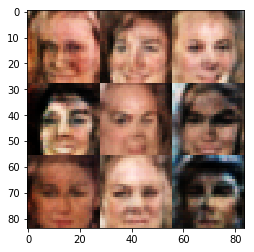

Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.4095
Epoch 1/1... Discriminator Loss: 0.5789... Generator Loss: 1.2369
Epoch 1/1... Discriminator Loss: 0.5753... Generator Loss: 1.0451
Epoch 1/1... Discriminator Loss: 0.4206... Generator Loss: 2.4064
Epoch 1/1... Discriminator Loss: 1.7476... Generator Loss: 0.2837
Epoch 1/1... Discriminator Loss: 0.7326... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 0.7979... Generator Loss: 1.0737
Epoch 1/1... Discriminator Loss: 0.3417... Generator Loss: 2.7227
Epoch 1/1... Discriminator Loss: 0.4377... Generator Loss: 1.4301
Epoch 1/1... Discriminator Loss: 0.7484... Generator Loss: 1.8153


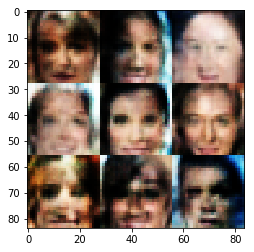

Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 0.9736... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 0.9391... Generator Loss: 0.9360
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.9747
Epoch 1/1... Discriminator Loss: 0.9430... Generator Loss: 0.9937
Epoch 1/1... Discriminator Loss: 1.5446... Generator Loss: 0.3755
Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 0.9534
Epoch 1/1... Discriminator Loss: 0.6651... Generator Loss: 1.0753
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 0.5640
Epoch 1/1... Discriminator Loss: 2.7873... Generator Loss: 0.9713


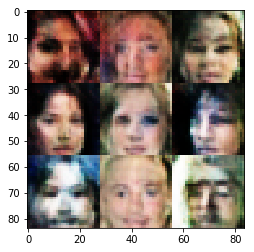

Epoch 1/1... Discriminator Loss: 0.1688... Generator Loss: 2.2114
Epoch 1/1... Discriminator Loss: 0.4389... Generator Loss: 2.0826
Epoch 1/1... Discriminator Loss: 0.1302... Generator Loss: 2.7704
Epoch 1/1... Discriminator Loss: 0.2020... Generator Loss: 1.9967
Epoch 1/1... Discriminator Loss: 0.7513... Generator Loss: 0.9428
Epoch 1/1... Discriminator Loss: 0.8485... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 0.7000... Generator Loss: 1.1875
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 1.0395... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.0045... Generator Loss: 0.8838


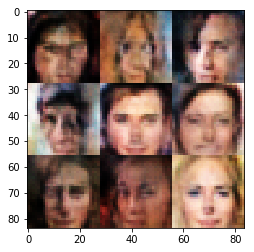

Epoch 1/1... Discriminator Loss: 0.9464... Generator Loss: 0.9106
Epoch 1/1... Discriminator Loss: 0.8114... Generator Loss: 0.9229
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 1.3081
Epoch 1/1... Discriminator Loss: 1.0972... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 0.8925... Generator Loss: 0.8455
Epoch 1/1... Discriminator Loss: 1.6218... Generator Loss: 0.4110
Epoch 1/1... Discriminator Loss: 0.9474... Generator Loss: 0.9126
Epoch 1/1... Discriminator Loss: 1.0465... Generator Loss: 1.1098
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 1.0568
Epoch 1/1... Discriminator Loss: 1.0150... Generator Loss: 1.0128


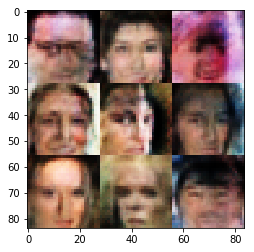

Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 0.5386
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.0679... Generator Loss: 0.5890
Epoch 1/1... Discriminator Loss: 0.8781... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 1.1218
Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 0.6126


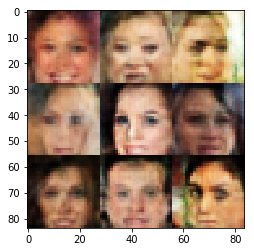

Epoch 1/1... Discriminator Loss: 0.8624... Generator Loss: 1.4239
Epoch 1/1... Discriminator Loss: 1.0865... Generator Loss: 0.8639
Epoch 1/1... Discriminator Loss: 1.0634... Generator Loss: 1.0096
Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 0.5011
Epoch 1/1... Discriminator Loss: 1.0573... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 0.9199... Generator Loss: 1.7131
Epoch 1/1... Discriminator Loss: 0.9445... Generator Loss: 0.8334


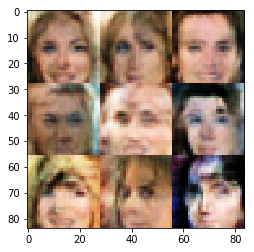

Epoch 1/1... Discriminator Loss: 1.0129... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 0.9951... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 0.9520... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 0.8582... Generator Loss: 1.5678
Epoch 1/1... Discriminator Loss: 1.0395... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 0.5613... Generator Loss: 1.4278
Epoch 1/1... Discriminator Loss: 0.6502... Generator Loss: 0.9893
Epoch 1/1... Discriminator Loss: 0.9448... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 0.6237


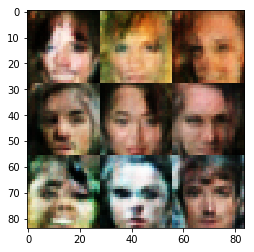

Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.0518... Generator Loss: 0.5795
Epoch 1/1... Discriminator Loss: 1.5204... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 0.8808... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 0.7714... Generator Loss: 1.0511
Epoch 1/1... Discriminator Loss: 0.8347... Generator Loss: 0.9935
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.5408
Epoch 1/1... Discriminator Loss: 1.0442... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 1.0341... Generator Loss: 0.6726


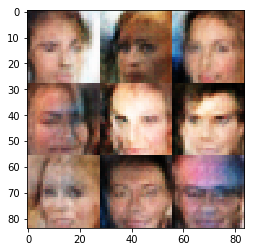

Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 0.4589
Epoch 1/1... Discriminator Loss: 0.8413... Generator Loss: 1.5056
Epoch 1/1... Discriminator Loss: 1.7687... Generator Loss: 0.9157
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 0.5731
Epoch 1/1... Discriminator Loss: 2.0088... Generator Loss: 2.0065
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 0.9798... Generator Loss: 0.9551
Epoch 1/1... Discriminator Loss: 0.9012... Generator Loss: 1.0370
Epoch 1/1... Discriminator Loss: 0.7667... Generator Loss: 1.9503


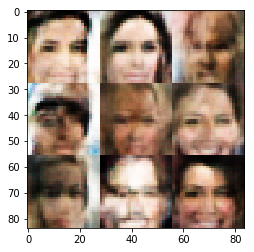

Epoch 1/1... Discriminator Loss: 0.5659... Generator Loss: 1.1935
Epoch 1/1... Discriminator Loss: 0.4853... Generator Loss: 1.1669
Epoch 1/1... Discriminator Loss: 0.6507... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 2.4441... Generator Loss: 3.3614
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.5244
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.5392
Epoch 1/1... Discriminator Loss: 0.8542... Generator Loss: 1.2220
Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 0.9365
Epoch 1/1... Discriminator Loss: 0.2073... Generator Loss: 2.5805
Epoch 1/1... Discriminator Loss: 2.0216... Generator Loss: 0.3284


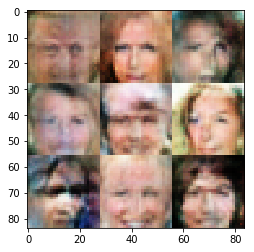

Epoch 1/1... Discriminator Loss: 0.9261... Generator Loss: 1.0591
Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 1.0135
Epoch 1/1... Discriminator Loss: 1.0823... Generator Loss: 0.8585
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.4504
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 0.8767... Generator Loss: 1.1452
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.4893
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 0.9374


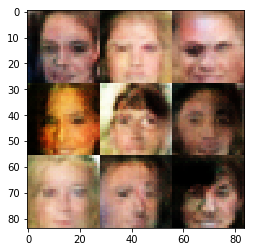

Epoch 1/1... Discriminator Loss: 0.8823... Generator Loss: 0.9650
Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.0500... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 0.8372
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 1.1621
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.5026
Epoch 1/1... Discriminator Loss: 0.8702... Generator Loss: 0.9571
Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 0.7238


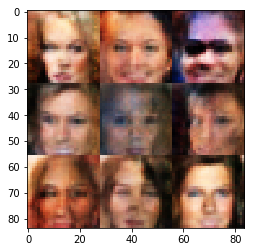

Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 0.7806... Generator Loss: 0.9989
Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 0.5628
Epoch 1/1... Discriminator Loss: 1.0277... Generator Loss: 0.8804
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 0.8514... Generator Loss: 0.9004


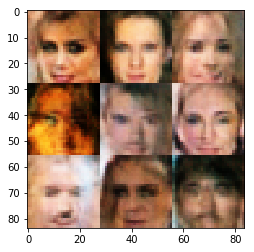

Epoch 1/1... Discriminator Loss: 0.3954... Generator Loss: 2.3248
Epoch 1/1... Discriminator Loss: 0.7482... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 1.7483... Generator Loss: 0.2802
Epoch 1/1... Discriminator Loss: 0.9884... Generator Loss: 1.2665
Epoch 1/1... Discriminator Loss: 0.9661... Generator Loss: 1.1871
Epoch 1/1... Discriminator Loss: 0.8518... Generator Loss: 1.2294
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 0.5079
Epoch 1/1... Discriminator Loss: 0.6708... Generator Loss: 1.4271
Epoch 1/1... Discriminator Loss: 0.7462... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 3.0762... Generator Loss: 0.0816


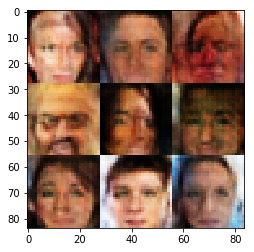

Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.5403
Epoch 1/1... Discriminator Loss: 0.2143... Generator Loss: 2.6958
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 0.9830
Epoch 1/1... Discriminator Loss: 0.8239... Generator Loss: 0.9388
Epoch 1/1... Discriminator Loss: 2.0715... Generator Loss: 0.1695
Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 1.2357
Epoch 1/1... Discriminator Loss: 0.7053... Generator Loss: 2.3769
Epoch 1/1... Discriminator Loss: 0.6285... Generator Loss: 1.1231
Epoch 1/1... Discriminator Loss: 0.3547... Generator Loss: 1.4233
Epoch 1/1... Discriminator Loss: 0.3959... Generator Loss: 2.9219


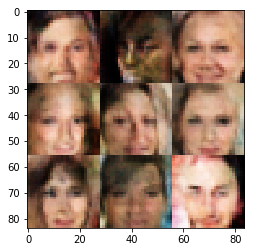

Epoch 1/1... Discriminator Loss: 1.6561... Generator Loss: 2.7283
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 0.9906... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 0.9590
Epoch 1/1... Discriminator Loss: 0.9298... Generator Loss: 1.0157
Epoch 1/1... Discriminator Loss: 1.1520... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.6132
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.0156... Generator Loss: 0.7918


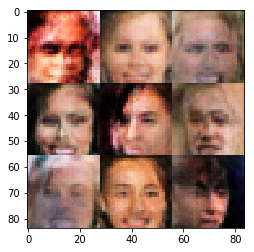

Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 0.9099
Epoch 1/1... Discriminator Loss: 1.0719... Generator Loss: 1.2049
Epoch 1/1... Discriminator Loss: 0.7976... Generator Loss: 0.8647
Epoch 1/1... Discriminator Loss: 0.9474... Generator Loss: 0.9578
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.5052
Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 0.5699
Epoch 1/1... Discriminator Loss: 1.1366... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.4516
Epoch 1/1... Discriminator Loss: 0.9201... Generator Loss: 1.0575
Epoch 1/1... Discriminator Loss: 1.1442... Generator Loss: 0.6051


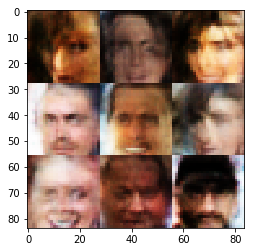

Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.5397
Epoch 1/1... Discriminator Loss: 0.9851... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.8881
Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 0.8085... Generator Loss: 1.0557
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.5009
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 0.8655
Epoch 1/1... Discriminator Loss: 0.4513... Generator Loss: 1.3398
Epoch 1/1... Discriminator Loss: 0.6788... Generator Loss: 2.1294
Epoch 1/1... Discriminator Loss: 0.7334... Generator Loss: 0.7683


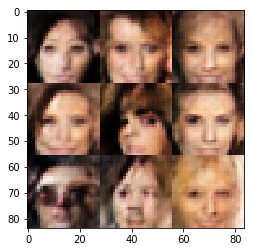

Epoch 1/1... Discriminator Loss: 0.4782... Generator Loss: 3.0225
Epoch 1/1... Discriminator Loss: 2.1364... Generator Loss: 0.1718
Epoch 1/1... Discriminator Loss: 0.2137... Generator Loss: 2.9021
Epoch 1/1... Discriminator Loss: 0.2053... Generator Loss: 2.0061
Epoch 1/1... Discriminator Loss: 3.7680... Generator Loss: 5.1452
Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.4753
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 1.1108


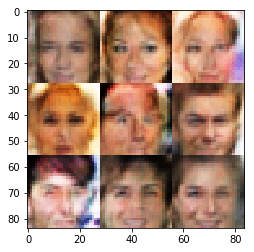

Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 0.7727... Generator Loss: 1.2061
Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 0.5384
Epoch 1/1... Discriminator Loss: 0.9819... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 0.8537... Generator Loss: 0.9944
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.9858
Epoch 1/1... Discriminator Loss: 0.2368... Generator Loss: 2.1148
Epoch 1/1... Discriminator Loss: 2.4648... Generator Loss: 2.9826
Epoch 1/1... Discriminator Loss: 0.1797... Generator Loss: 2.8657
Epoch 1/1... Discriminator Loss: 0.3936... Generator Loss: 1.8078


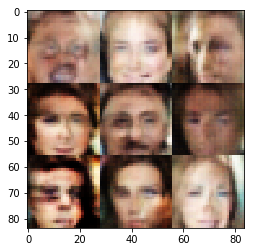

Epoch 1/1... Discriminator Loss: 0.4580... Generator Loss: 1.2909
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 0.7245... Generator Loss: 1.0288
Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 0.5313
Epoch 1/1... Discriminator Loss: 0.8815... Generator Loss: 1.1143
Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 0.7724... Generator Loss: 0.9307
Epoch 1/1... Discriminator Loss: 0.1941... Generator Loss: 2.4538
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.9541


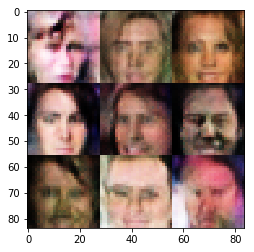

Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 0.8600... Generator Loss: 0.9669
Epoch 1/1... Discriminator Loss: 0.8781... Generator Loss: 0.9929
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.5297
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.4967
Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 1.0641
Epoch 1/1... Discriminator Loss: 1.0814... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 0.8109... Generator Loss: 1.1089
Epoch 1/1... Discriminator Loss: 1.0721... Generator Loss: 0.7558


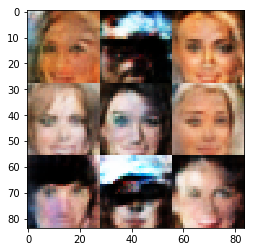

Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 0.8043... Generator Loss: 1.1951
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 0.9458... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 1.0720
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 1.2086
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.6365
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 0.5228
Epoch 1/1... Discriminator Loss: 0.7682... Generator Loss: 0.9639
Epoch 1/1... Discriminator Loss: 0.4210... Generator Loss: 1.2502


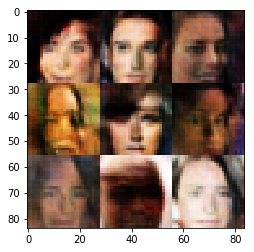

Epoch 1/1... Discriminator Loss: 0.7504... Generator Loss: 3.8626
Epoch 1/1... Discriminator Loss: 0.1398... Generator Loss: 2.5828
Epoch 1/1... Discriminator Loss: 0.0949... Generator Loss: 2.9649
Epoch 1/1... Discriminator Loss: 0.1401... Generator Loss: 2.8569
Epoch 1/1... Discriminator Loss: 0.9093... Generator Loss: 1.1435
Epoch 1/1... Discriminator Loss: 0.7104... Generator Loss: 1.1388
Epoch 1/1... Discriminator Loss: 0.9022... Generator Loss: 1.1503
Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 0.8737
Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 0.8884
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 0.9666


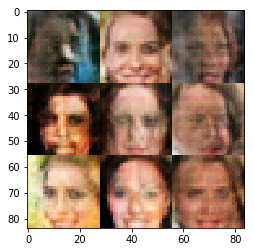

Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 0.5570
Epoch 1/1... Discriminator Loss: 0.8946... Generator Loss: 0.9707
Epoch 1/1... Discriminator Loss: 1.0058... Generator Loss: 1.0450
Epoch 1/1... Discriminator Loss: 1.0339... Generator Loss: 1.0512
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 1.0764
Epoch 1/1... Discriminator Loss: 0.9863... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 0.8920... Generator Loss: 1.0059
Epoch 1/1... Discriminator Loss: 1.0419... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 0.7133


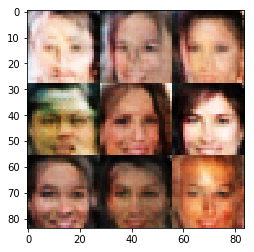

Epoch 1/1... Discriminator Loss: 1.0187... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 0.8000... Generator Loss: 1.1900
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 1.1610
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 0.5925
Epoch 1/1... Discriminator Loss: 1.0114... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 0.7032


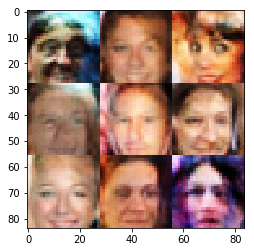

Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.4546
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 0.5857
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 1.0503
Epoch 1/1... Discriminator Loss: 0.9485... Generator Loss: 0.9579
Epoch 1/1... Discriminator Loss: 0.7962... Generator Loss: 1.1484
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.1262... Generator Loss: 0.8670


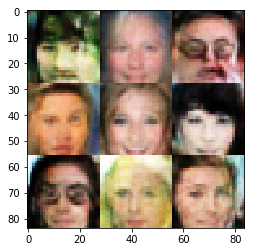

Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.5557
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 1.0366
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.4193
Epoch 1/1... Discriminator Loss: 0.9311... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 0.5537
Epoch 1/1... Discriminator Loss: 0.8460... Generator Loss: 0.9764


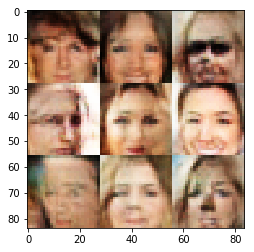

Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 0.8825
Epoch 1/1... Discriminator Loss: 1.1921... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 0.9499... Generator Loss: 0.8965
Epoch 1/1... Discriminator Loss: 0.3921... Generator Loss: 1.5189
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 0.3149... Generator Loss: 2.8946
Epoch 1/1... Discriminator Loss: 0.3206... Generator Loss: 1.5062
Epoch 1/1... Discriminator Loss: 0.7888... Generator Loss: 0.9921
Epoch 1/1... Discriminator Loss: 0.8113... Generator Loss: 1.1461


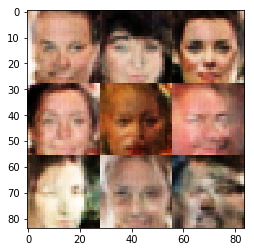

Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 0.5256
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.5593
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.3550
Epoch 1/1... Discriminator Loss: 0.3226... Generator Loss: 1.4165
Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 0.9587... Generator Loss: 1.0388
Epoch 1/1... Discriminator Loss: 0.6777... Generator Loss: 3.7395
Epoch 1/1... Discriminator Loss: 1.1888... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 0.8479... Generator Loss: 0.8985
Epoch 1/1... Discriminator Loss: 1.0780... Generator Loss: 0.8229


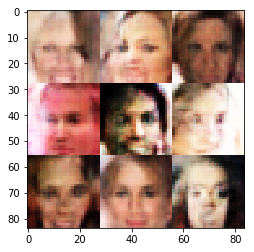

Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 1.0417
Epoch 1/1... Discriminator Loss: 0.8159... Generator Loss: 1.3453
Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 0.9199... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 0.9647... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 1.0847... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 0.9031... Generator Loss: 1.0285
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 0.7782... Generator Loss: 1.1382


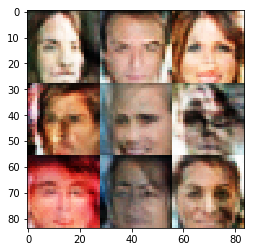

Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 0.9377... Generator Loss: 0.9383
Epoch 1/1... Discriminator Loss: 0.8619... Generator Loss: 0.9143
Epoch 1/1... Discriminator Loss: 0.9835... Generator Loss: 0.9480
Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.0623... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.0976... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.4962
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 0.6889


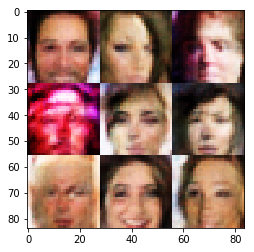

Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 0.5420
Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 0.8980... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 0.5599
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 0.8248... Generator Loss: 1.0120
Epoch 1/1... Discriminator Loss: 1.0384... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 0.8073... Generator Loss: 1.3376


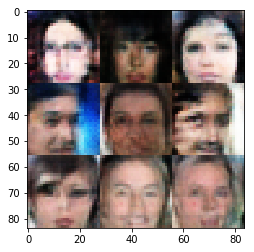

Epoch 1/1... Discriminator Loss: 0.3867... Generator Loss: 1.2870
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.4730
Epoch 1/1... Discriminator Loss: 0.9749... Generator Loss: 0.9373
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 0.9385... Generator Loss: 1.0642
Epoch 1/1... Discriminator Loss: 0.7933... Generator Loss: 1.1403
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.4568
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 0.8881
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 0.9796... Generator Loss: 1.2350


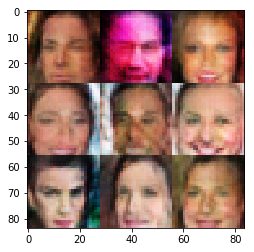

Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.4722
Epoch 1/1... Discriminator Loss: 0.7318... Generator Loss: 1.4868
Epoch 1/1... Discriminator Loss: 0.6343... Generator Loss: 0.9139
Epoch 1/1... Discriminator Loss: 0.1751... Generator Loss: 2.2164
Epoch 1/1... Discriminator Loss: 0.0895... Generator Loss: 2.8302
Epoch 1/1... Discriminator Loss: 0.0486... Generator Loss: 3.5711
Epoch 1/1... Discriminator Loss: 0.0538... Generator Loss: 3.3841
Epoch 1/1... Discriminator Loss: 0.0283... Generator Loss: 3.9654
Epoch 1/1... Discriminator Loss: 0.0139... Generator Loss: 4.5502
Epoch 1/1... Discriminator Loss: 0.0100... Generator Loss: 5.2298


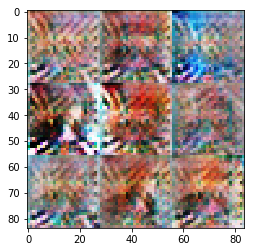

Epoch 1/1... Discriminator Loss: 0.0167... Generator Loss: 4.4673
Epoch 1/1... Discriminator Loss: 0.0313... Generator Loss: 3.9560
Epoch 1/1... Discriminator Loss: 0.0204... Generator Loss: 4.3694
Epoch 1/1... Discriminator Loss: 0.0057... Generator Loss: 5.3799
Epoch 1/1... Discriminator Loss: 0.0008... Generator Loss: 8.1160
Epoch 1/1... Discriminator Loss: 0.0037... Generator Loss: 5.8921
Epoch 1/1... Discriminator Loss: 0.0017... Generator Loss: 6.8695
Epoch 1/1... Discriminator Loss: 0.0022... Generator Loss: 6.4964
Epoch 1/1... Discriminator Loss: 0.0009... Generator Loss: 8.1383
Epoch 1/1... Discriminator Loss: 0.0028... Generator Loss: 6.2074


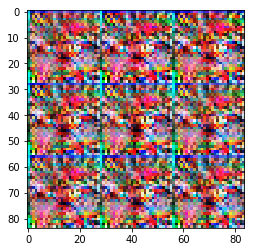

Epoch 1/1... Discriminator Loss: 0.0009... Generator Loss: 7.7439
Epoch 1/1... Discriminator Loss: 0.0008... Generator Loss: 10.1007
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 12.1912
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 9.9668
Epoch 1/1... Discriminator Loss: 0.0105... Generator Loss: 4.6605
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 10.0668
Epoch 1/1... Discriminator Loss: 0.0005... Generator Loss: 8.7993
Epoch 1/1... Discriminator Loss: 0.0007... Generator Loss: 13.6646
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 9.1263
Epoch 1/1... Discriminator Loss: 0.0037... Generator Loss: 5.7860


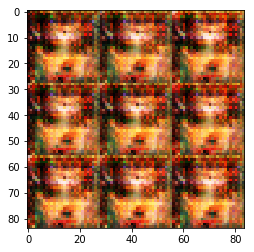

Epoch 1/1... Discriminator Loss: 0.0010... Generator Loss: 7.5286
Epoch 1/1... Discriminator Loss: 0.1193... Generator Loss: 4.3968
Epoch 1/1... Discriminator Loss: 0.5755... Generator Loss: 1.2727
Epoch 1/1... Discriminator Loss: 0.0500... Generator Loss: 8.8325
Epoch 1/1... Discriminator Loss: 0.4232... Generator Loss: 1.3100
Epoch 1/1... Discriminator Loss: 0.2228... Generator Loss: 2.1024
Epoch 1/1... Discriminator Loss: 0.2398... Generator Loss: 1.8967
Epoch 1/1... Discriminator Loss: 0.0100... Generator Loss: 6.1880
Epoch 1/1... Discriminator Loss: 0.0564... Generator Loss: 3.5423
Epoch 1/1... Discriminator Loss: 0.2369... Generator Loss: 7.4537


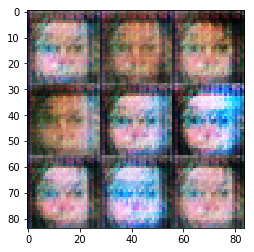

Epoch 1/1... Discriminator Loss: 0.1691... Generator Loss: 7.5643
Epoch 1/1... Discriminator Loss: 0.3315... Generator Loss: 2.2269
Epoch 1/1... Discriminator Loss: 0.0941... Generator Loss: 3.0764
Epoch 1/1... Discriminator Loss: 0.6972... Generator Loss: 1.3976
Epoch 1/1... Discriminator Loss: 0.5750... Generator Loss: 1.1434
Epoch 1/1... Discriminator Loss: 0.0784... Generator Loss: 5.6883
Epoch 1/1... Discriminator Loss: 0.1250... Generator Loss: 3.2238
Epoch 1/1... Discriminator Loss: 0.0394... Generator Loss: 3.7235
Epoch 1/1... Discriminator Loss: 0.6256... Generator Loss: 1.0216
Epoch 1/1... Discriminator Loss: 0.3304... Generator Loss: 1.8061


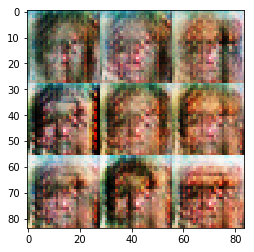

Epoch 1/1... Discriminator Loss: 0.0167... Generator Loss: 6.2954
Epoch 1/1... Discriminator Loss: 0.0513... Generator Loss: 3.5067
Epoch 1/1... Discriminator Loss: 0.0822... Generator Loss: 2.7972
Epoch 1/1... Discriminator Loss: 0.0114... Generator Loss: 8.5553
Epoch 1/1... Discriminator Loss: 0.0034... Generator Loss: 7.8162
Epoch 1/1... Discriminator Loss: 0.0140... Generator Loss: 4.8250
Epoch 1/1... Discriminator Loss: 0.0033... Generator Loss: 8.2152
Epoch 1/1... Discriminator Loss: 0.0404... Generator Loss: 3.4624
Epoch 1/1... Discriminator Loss: 0.0027... Generator Loss: 9.3312
Epoch 1/1... Discriminator Loss: 0.0047... Generator Loss: 6.4898


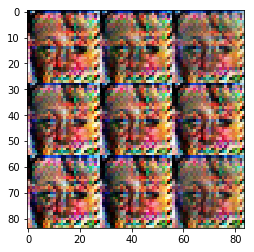

Epoch 1/1... Discriminator Loss: 0.0019... Generator Loss: 10.9629
Epoch 1/1... Discriminator Loss: 0.0011... Generator Loss: 9.8424
Epoch 1/1... Discriminator Loss: 0.0006... Generator Loss: 9.0293
Epoch 1/1... Discriminator Loss: 0.0033... Generator Loss: 6.3578
Epoch 1/1... Discriminator Loss: 0.0577... Generator Loss: 4.1744
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 0.2611... Generator Loss: 4.0248
Epoch 1/1... Discriminator Loss: 0.1180... Generator Loss: 2.7401
Epoch 1/1... Discriminator Loss: 0.0497... Generator Loss: 4.0171
Epoch 1/1... Discriminator Loss: 0.3148... Generator Loss: 1.6584


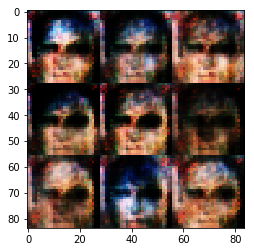

Epoch 1/1... Discriminator Loss: 0.2149... Generator Loss: 2.7425
Epoch 1/1... Discriminator Loss: 0.0140... Generator Loss: 6.4203
Epoch 1/1... Discriminator Loss: 0.0999... Generator Loss: 2.9904
Epoch 1/1... Discriminator Loss: 0.1870... Generator Loss: 4.1526
Epoch 1/1... Discriminator Loss: 0.5848... Generator Loss: 1.1839
Epoch 1/1... Discriminator Loss: 0.2525... Generator Loss: 9.7606
Epoch 1/1... Discriminator Loss: 0.2343... Generator Loss: 2.5493
Epoch 1/1... Discriminator Loss: 0.3887... Generator Loss: 1.7006
Epoch 1/1... Discriminator Loss: 0.1269... Generator Loss: 4.0202
Epoch 1/1... Discriminator Loss: 0.4008... Generator Loss: 1.4185


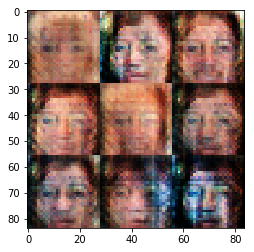

Epoch 1/1... Discriminator Loss: 0.7889... Generator Loss: 1.0149
Epoch 1/1... Discriminator Loss: 0.1215... Generator Loss: 2.9310
Epoch 1/1... Discriminator Loss: 0.7958... Generator Loss: 0.9435
Epoch 1/1... Discriminator Loss: 0.2975... Generator Loss: 1.9020
Epoch 1/1... Discriminator Loss: 0.2418... Generator Loss: 2.1328
Epoch 1/1... Discriminator Loss: 0.2097... Generator Loss: 2.2902
Epoch 1/1... Discriminator Loss: 0.4818... Generator Loss: 1.5624
Epoch 1/1... Discriminator Loss: 0.7380... Generator Loss: 5.1289
Epoch 1/1... Discriminator Loss: 0.8893... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 0.2921... Generator Loss: 2.5252


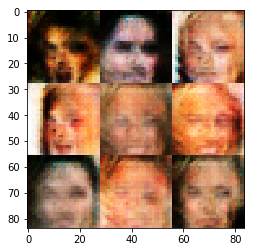

Epoch 1/1... Discriminator Loss: 0.3618... Generator Loss: 4.7337
Epoch 1/1... Discriminator Loss: 0.8008... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 0.1239... Generator Loss: 5.4147
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 1.3121
Epoch 1/1... Discriminator Loss: 0.3862... Generator Loss: 1.5913
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 0.5058
Epoch 1/1... Discriminator Loss: 0.6965... Generator Loss: 3.6977
Epoch 1/1... Discriminator Loss: 0.2683... Generator Loss: 2.3649
Epoch 1/1... Discriminator Loss: 0.5310... Generator Loss: 1.2243
Epoch 1/1... Discriminator Loss: 0.3440... Generator Loss: 2.2468


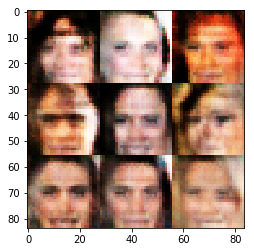

Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 4.5355
Epoch 1/1... Discriminator Loss: 0.8074... Generator Loss: 1.2675
Epoch 1/1... Discriminator Loss: 0.5465... Generator Loss: 1.4313
Epoch 1/1... Discriminator Loss: 1.5861... Generator Loss: 0.3608
Epoch 1/1... Discriminator Loss: 0.6790... Generator Loss: 1.2397
Epoch 1/1... Discriminator Loss: 0.3232... Generator Loss: 1.7815
Epoch 1/1... Discriminator Loss: 0.5740... Generator Loss: 3.9247
Epoch 1/1... Discriminator Loss: 1.6191... Generator Loss: 0.2981
Epoch 1/1... Discriminator Loss: 0.4931... Generator Loss: 2.0410
Epoch 1/1... Discriminator Loss: 1.0451... Generator Loss: 0.8261


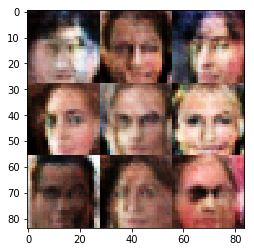

Epoch 1/1... Discriminator Loss: 0.8918... Generator Loss: 2.1559
Epoch 1/1... Discriminator Loss: 0.8890... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 0.6220... Generator Loss: 2.5000
Epoch 1/1... Discriminator Loss: 1.7002... Generator Loss: 0.3178
Epoch 1/1... Discriminator Loss: 0.8010... Generator Loss: 2.5402
Epoch 1/1... Discriminator Loss: 0.8777... Generator Loss: 1.1814
Epoch 1/1... Discriminator Loss: 0.8141... Generator Loss: 0.8915
Epoch 1/1... Discriminator Loss: 0.6000... Generator Loss: 1.6197
Epoch 1/1... Discriminator Loss: 0.9623... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.3901


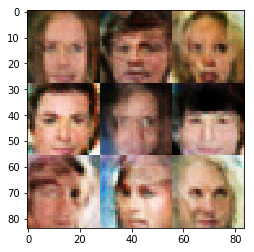

Epoch 1/1... Discriminator Loss: 0.2772... Generator Loss: 2.2550
Epoch 1/1... Discriminator Loss: 2.7462... Generator Loss: 0.2749
Epoch 1/1... Discriminator Loss: 0.9609... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 0.8022... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 0.8469... Generator Loss: 3.2536
Epoch 1/1... Discriminator Loss: 0.6035... Generator Loss: 1.1554
Epoch 1/1... Discriminator Loss: 2.8373... Generator Loss: 0.1249
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 0.5343
Epoch 1/1... Discriminator Loss: 0.7239... Generator Loss: 0.9038
Epoch 1/1... Discriminator Loss: 0.5931... Generator Loss: 1.4931


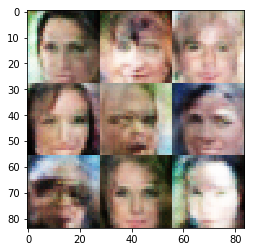

Epoch 1/1... Discriminator Loss: 0.5593... Generator Loss: 1.5284
Epoch 1/1... Discriminator Loss: 0.7407... Generator Loss: 1.7171
Epoch 1/1... Discriminator Loss: 0.7395... Generator Loss: 1.7388
Epoch 1/1... Discriminator Loss: 0.6252... Generator Loss: 1.3834
Epoch 1/1... Discriminator Loss: 0.9828... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 0.9710... Generator Loss: 1.0210
Epoch 1/1... Discriminator Loss: 0.9894... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 0.9075... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 1.1112... Generator Loss: 0.5177
Epoch 1/1... Discriminator Loss: 0.9014... Generator Loss: 1.0034


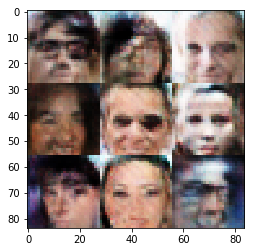

Epoch 1/1... Discriminator Loss: 0.7833... Generator Loss: 1.4833
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 0.5911
Epoch 1/1... Discriminator Loss: 0.9614... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 0.8435... Generator Loss: 0.9759
Epoch 1/1... Discriminator Loss: 0.6705... Generator Loss: 1.3480
Epoch 1/1... Discriminator Loss: 0.9868... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.0097... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 0.6703


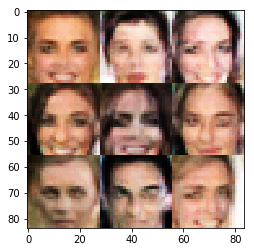

Epoch 1/1... Discriminator Loss: 0.8001... Generator Loss: 1.5930
Epoch 1/1... Discriminator Loss: 0.9731... Generator Loss: 0.9563
Epoch 1/1... Discriminator Loss: 0.8082... Generator Loss: 1.8319
Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 0.9240... Generator Loss: 1.0795
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.4299
Epoch 1/1... Discriminator Loss: 0.8270... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 1.2471
Epoch 1/1... Discriminator Loss: 0.8675... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 0.7954... Generator Loss: 1.1293


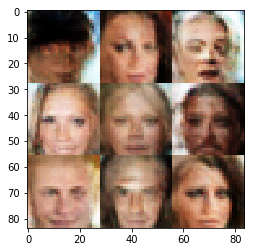

Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 0.5638
Epoch 1/1... Discriminator Loss: 0.8015... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.4656
Epoch 1/1... Discriminator Loss: 0.8814... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 0.7157... Generator Loss: 1.2681
Epoch 1/1... Discriminator Loss: 1.5934... Generator Loss: 0.4117
Epoch 1/1... Discriminator Loss: 0.9775... Generator Loss: 1.1486
Epoch 1/1... Discriminator Loss: 0.4703... Generator Loss: 1.1869
Epoch 1/1... Discriminator Loss: 2.9038... Generator Loss: 1.3709
Epoch 1/1... Discriminator Loss: 0.3959... Generator Loss: 1.7465


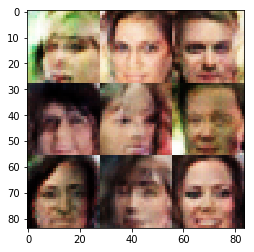

Epoch 1/1... Discriminator Loss: 0.2412... Generator Loss: 2.6256
Epoch 1/1... Discriminator Loss: 2.2853... Generator Loss: 0.1449
Epoch 1/1... Discriminator Loss: 2.0742... Generator Loss: 0.1869
Epoch 1/1... Discriminator Loss: 1.0256... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 0.9906... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 1.2093
Epoch 1/1... Discriminator Loss: 0.9975... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 0.6872... Generator Loss: 1.2243
Epoch 1/1... Discriminator Loss: 0.6809... Generator Loss: 1.2900


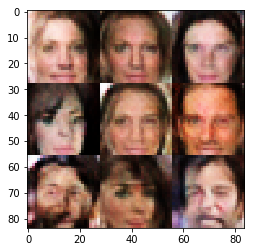

Epoch 1/1... Discriminator Loss: 1.1513... Generator Loss: 0.6330
Epoch 1/1... Discriminator Loss: 0.8037... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 0.8303... Generator Loss: 1.0366
Epoch 1/1... Discriminator Loss: 0.8817... Generator Loss: 1.0589
Epoch 1/1... Discriminator Loss: 0.7310... Generator Loss: 0.9945
Epoch 1/1... Discriminator Loss: 0.8383... Generator Loss: 1.3789
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 0.6027
Epoch 1/1... Discriminator Loss: 0.5921... Generator Loss: 1.4954
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.4684
Epoch 1/1... Discriminator Loss: 1.0900... Generator Loss: 0.6256


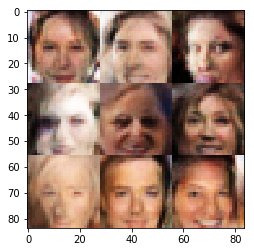

Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 0.4083
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.5392
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 0.7522... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 0.7413... Generator Loss: 1.0457
Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 0.8232... Generator Loss: 0.9291
Epoch 1/1... Discriminator Loss: 0.8894... Generator Loss: 1.0142
Epoch 1/1... Discriminator Loss: 0.8980... Generator Loss: 0.8030


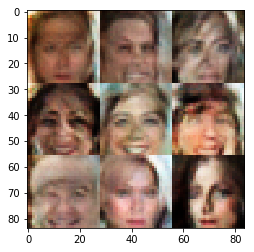

Epoch 1/1... Discriminator Loss: 0.6073... Generator Loss: 1.2093
Epoch 1/1... Discriminator Loss: 0.1322... Generator Loss: 2.8318
Epoch 1/1... Discriminator Loss: 0.1215... Generator Loss: 2.4568
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 0.7385... Generator Loss: 2.0210
Epoch 1/1... Discriminator Loss: 0.6632... Generator Loss: 2.0778
Epoch 1/1... Discriminator Loss: 1.7504... Generator Loss: 0.3002
Epoch 1/1... Discriminator Loss: 0.9030... Generator Loss: 0.8590
Epoch 1/1... Discriminator Loss: 0.8110... Generator Loss: 1.5269
Epoch 1/1... Discriminator Loss: 0.8229... Generator Loss: 1.1267


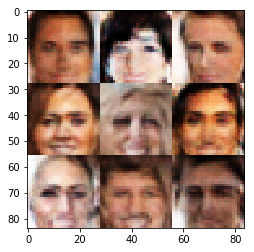

Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 0.5913
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 0.6286
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.6079
Epoch 1/1... Discriminator Loss: 0.8481... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 0.5631
Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.5760... Generator Loss: 0.3047
Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 0.8921
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 1.0164


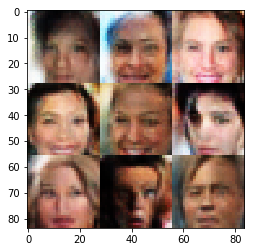

Epoch 1/1... Discriminator Loss: 0.8558... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 0.8883
Epoch 1/1... Discriminator Loss: 0.9264... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 0.9873... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.0177... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 0.7487... Generator Loss: 1.2656
Epoch 1/1... Discriminator Loss: 1.0245... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 0.8280... Generator Loss: 1.2204
Epoch 1/1... Discriminator Loss: 0.8661... Generator Loss: 1.1601
Epoch 1/1... Discriminator Loss: 0.8992... Generator Loss: 1.0798


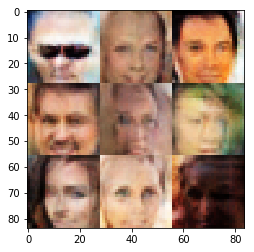

Epoch 1/1... Discriminator Loss: 0.9372... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 0.7386... Generator Loss: 1.0984
Epoch 1/1... Discriminator Loss: 0.4517... Generator Loss: 1.1165
Epoch 1/1... Discriminator Loss: 0.8845... Generator Loss: 1.5532
Epoch 1/1... Discriminator Loss: 0.8496... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 2.2849... Generator Loss: 0.1616
Epoch 1/1... Discriminator Loss: 0.8143... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 0.8326... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.0292... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.6290


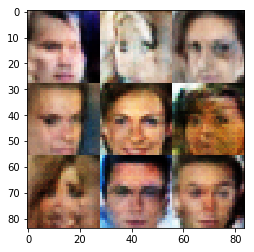

Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 0.5939
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 0.9693... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 0.9320... Generator Loss: 1.0552
Epoch 1/1... Discriminator Loss: 0.8189... Generator Loss: 1.0422
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 0.4875
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 0.5315
Epoch 1/1... Discriminator Loss: 0.9700... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 0.6990... Generator Loss: 1.0936
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.9202


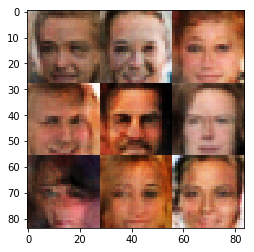

Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 0.5984
Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 0.5672
Epoch 1/1... Discriminator Loss: 0.9808... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 0.8768... Generator Loss: 0.9441
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 0.6119
Epoch 1/1... Discriminator Loss: 1.0425... Generator Loss: 1.1062
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 0.7824... Generator Loss: 1.0049
Epoch 1/1... Discriminator Loss: 0.8055... Generator Loss: 1.0652
Epoch 1/1... Discriminator Loss: 0.8479... Generator Loss: 0.8371


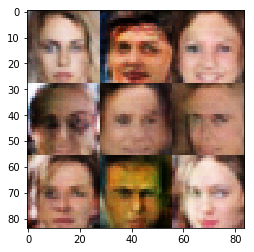

Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 0.5605
Epoch 1/1... Discriminator Loss: 0.9946... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 0.9134... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.4901
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 0.5567
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.5550
Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 0.5499


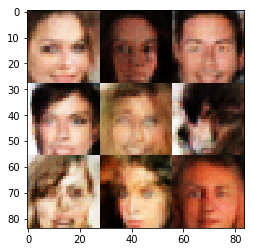

Epoch 1/1... Discriminator Loss: 0.9486... Generator Loss: 1.0062
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 0.4798
Epoch 1/1... Discriminator Loss: 0.8310... Generator Loss: 0.9388
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.5381
Epoch 1/1... Discriminator Loss: 0.9606... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 0.9091... Generator Loss: 0.9947
Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 0.5252
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 0.5047


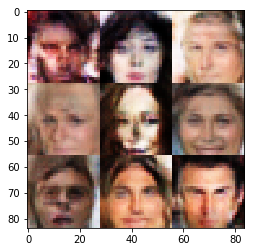

Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.5348
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 0.9428... Generator Loss: 1.0664
Epoch 1/1... Discriminator Loss: 0.6776... Generator Loss: 1.3809
Epoch 1/1... Discriminator Loss: 0.9443... Generator Loss: 0.9189
Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.0324... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 0.9992... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 0.7108


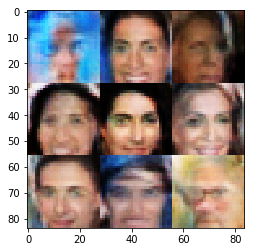

Epoch 1/1... Discriminator Loss: 0.9708... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.4985
Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 0.5716
Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 0.8890... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.5754
Epoch 1/1... Discriminator Loss: 0.8211... Generator Loss: 1.0537
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 0.4667
Epoch 1/1... Discriminator Loss: 0.7896... Generator Loss: 1.1919
Epoch 1/1... Discriminator Loss: 1.2370... Generator Loss: 0.5225


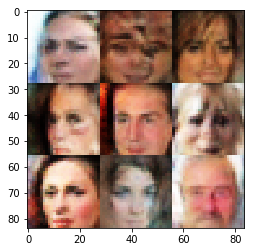

Epoch 1/1... Discriminator Loss: 0.7928... Generator Loss: 0.9774
Epoch 1/1... Discriminator Loss: 0.2226... Generator Loss: 1.8881
Epoch 1/1... Discriminator Loss: 0.1204... Generator Loss: 3.4783
Epoch 1/1... Discriminator Loss: 0.0648... Generator Loss: 4.3878
Epoch 1/1... Discriminator Loss: 0.0410... Generator Loss: 4.0707
Epoch 1/1... Discriminator Loss: 1.0808... Generator Loss: 0.4985
Epoch 1/1... Discriminator Loss: 0.8961... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 0.8739... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 0.5904... Generator Loss: 1.3235
Epoch 1/1... Discriminator Loss: 0.9341... Generator Loss: 0.8274


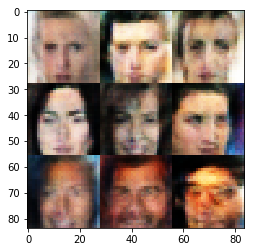

Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 0.9274... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.4141
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.0782... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 0.8242... Generator Loss: 1.0771
Epoch 1/1... Discriminator Loss: 0.8128... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.5015
Epoch 1/1... Discriminator Loss: 0.9958... Generator Loss: 1.0161
Epoch 1/1... Discriminator Loss: 0.7669... Generator Loss: 1.3434


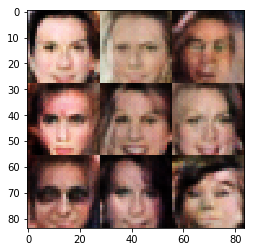

Epoch 1/1... Discriminator Loss: 0.9133... Generator Loss: 0.9661
Epoch 1/1... Discriminator Loss: 1.0709... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 0.8579... Generator Loss: 1.0898
Epoch 1/1... Discriminator Loss: 1.0909... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.3867
Epoch 1/1... Discriminator Loss: 0.9972... Generator Loss: 1.0011
Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 0.9915... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 0.8779... Generator Loss: 1.0227


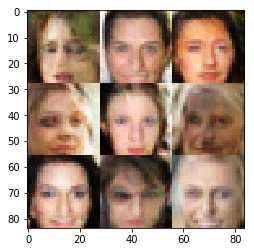

Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.9561
Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 1.1627
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 0.7852... Generator Loss: 0.9819
Epoch 1/1... Discriminator Loss: 0.8769... Generator Loss: 1.0894
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 0.9193
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.5008
Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 0.9096
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.5524
Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 0.5809


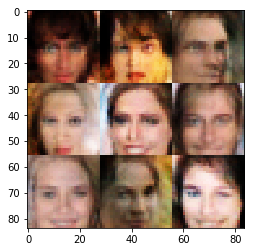

Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 1.0842
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 0.4518
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 1.0481
Epoch 1/1... Discriminator Loss: 0.8510... Generator Loss: 0.9834
Epoch 1/1... Discriminator Loss: 0.8859... Generator Loss: 0.9697
Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 0.8994


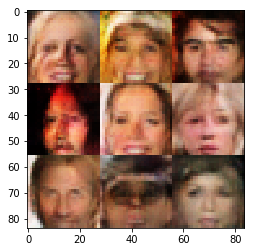

In [51]:
batch_size = 16
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.